## Explaining BERT-based hate speech detection with LIME and Saliency using Captum

It has been shown that BERT’s domain-specific fine-tuning approaches for hate speech detection are still competitive for hate speech classification (Roy et al., 2023). Although LLMs can also be used for classification tasks, they are trained on a wider domain of tasks and more data. Their predictive power is also tied to the right model instructions and decoding strategies. Roy et al. (2023) confirm that LLMs are sensitive to input variations and struggle in particular with implicit cases of hate speech. This aspect makes it also more difficult to probe LLMs with explainability methods. In contrast, BERT models, as classifiers, are easier to explain.

This notebook's idea is to investigate how well BERT-based hate speech detection is aligned with human judgments of German hate speech. To arrive at plausible explanations, we also need to determine which method, that is, a model agnostic simplification such as LIME or a gradient-based method such as Saliency, works best for our purpose.

As we can see in the following example, the explainability methods will tell us which tokens influenced BERT's prediction.

![example](./images/visualization_example_1.png)

### Overview
- Loading and preprocessing Gaze4Hate dataset
- Loading and initializing the BERT model for hate speech detection
- Deriving explanations through attributions from BERT with LIME
- Deriving explanations through attributions from BERT with Saliency
- Evaluating the results (human vs. BERT rationales)
- Visualizing the results (alignment)

Before we start, let us begin with installing and loading libraries, which we will use later in the project.

In [ ]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install scipy

!pip install transformers
!pip install torch torchvision
!pip install -U scikit-learn
!pip install openpyxl
!pip install captum
!pip install sentencepiece
!pip install ipywidgets

!pip show transformers

Name: transformers
Version: 4.49.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /Users/max/.pyenv/versions/3.12.0/lib/python3.12/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [2]:
# Basic libraries
from collections import defaultdict
from collections import Counter
from IPython.display import HTML, display
import json
from tqdm.notebook import tqdm
import os
import requests
import sys

# Colab
# from google.colab import drive

# Data libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# Deeplearning libraries
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from captum.attr import LimeBase, Saliency
from captum._utils.models.linear_model import SkLearnLasso

# Evaluation libraries
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import pearsonr


## Loading and preprocessing Gaze4Hate dataset

We use the GAZE4HATE dataset from Alacam et al. (2024), which consists of "hatefulness ratings of
text w.r.t. gender, eye movements during plain readings of the statements" (Alacam et al., 2024, p.189) from 43 participants (32 female, 10 male, 1 non-binary, Mean age = 23.5, SD = 5.3 as reported
in (Alacam et al., 2024)). The participants' ratings were gathered on a Likert scale from 1 to 7, where 1 corresponded to 'very positive' and 7 to 'extremely hateful'. 4 and 5 were considered as 'neutral' and 'mean'. The data comes with rationales for the participants' judgments. These rationales were collected through clicks on words that the participants found relevant. Conversely, if a word is not clicked, it is not considered a determining factor. Finally, the participants’ response were assigned to two hate annotations: the first measured the answers along the binary levels of 'hate' and 'no-hate' and the second along three levels, namely 'hate', 'neutral', and 'positive'. All participants saw all sentences in the data set.

In this project, we are interested in the explicit rationales, which we will later compare with BERT's attributions with respect to the words that influenced its predictions.

We can find and download the dataset under a CC-BY-NC 4.0 license from: [https://osf.io/fgdjw](https://osf.io/fgdjw)

In [3]:
# URL of the CSV file
url = "https://osf.io/download/fgdjw/"

# Downloading the file
try:
    response = requests.get(url)
except requests.ConnectionError:
    print("No internet connection")

# Saving it as a local CSV file
filename = "Gaze4Hate.csv"
with open(filename, "wb") as file:
    file.write(response.content)

print(f"File downloaded and saved as {filename}")

File downloaded and saved as Gaze4Hate.csv


In [ ]:
os.chdir("/path")
df = pd.read_csv("Gaze4Hate.csv", delimiter="\t")

"""
# Mount Google Drive
drive.mount('/content/gdrive')

PATH = r"/content/gdrive/My Drive/Colab Notebooks/EXPL_LIME"
os.chdir(PATH)

directory = os.getcwd()
df = pd.read_csv("Gaze4Hate_data.csv", delimiter="\t")"
"""

'\n# Mount Google Drive\ndrive.mount(\'/content/gdrive\')\n\nPATH = r"/content/gdrive/My Drive/Colab Notebooks/EXPL_LIME"\nos.chdir(PATH)\n\ndirectory = os.getcwd()\ndf = pd.read_csv("Gaze4Hate_data.csv", delimiter="\t")"\n'

Let's inspect the raw dataset.

In [5]:
df[(df["pno"] == "p1") & (df["sno"] == 19)]

,pno,TRIAL_INDEX,IA_Avg_Pupil,TDT,TFC,IA_FIXATION_%,IA_DWELL_TIME_%,IA_FFD,IA_LABEL,IA_Max_Pupil,...,cleaned_tokens,Ling_type,backward_reg_count,forward_reg_count,total_reg_count,Clicked,Intensity_Category,Intensity_Category_Binary,Var_Pupil,split
1434,p1,42,0.583072,2347.0,16,0.0000,0.000,0.207547,Word 1,0.521008,...,"['frauen', 'gehören', 'in', 'die', 'küche']",social,0.0,0.0,0.0,1,hate,1,0.0,train
1435,p1,42,0.583072,2347.0,16,0.0625,0.072,0.207547,Word 2,0.521008,...,"['frauen', 'gehören', 'in', 'die', 'küche']",social,0.0,0.0,0.0,0,hate,1,0.0,train
1436,p1,42,0.583072,2347.0,16,0.0000,0.000,0.207547,Word 3,0.521008,...,"['frauen', 'gehören', 'in', 'die', 'küche']",social,0.0,0.0,0.0,0,hate,1,0.0,train
1437,p1,42,0.583072,2347.0,16,0.0000,0.000,0.207547,Word 4,0.521008,...,"['frauen', 'gehören', 'in', 'die', 'küche']",social,0.0,0.0,0.0,0,hate,1,0.0,train
1438,p1,42,0.583072,2347.0,16,0.0000,0.000,0.207547,Word 5,0.521008,...,"['frauen', 'gehören', 'in', 'die', 'küche']",social,0.0,0.0,0.0,1,hate,1,0.0,train


We have many columns with different data, including the sentences, the participants' hate ratings in terms of gaze data, and click data. Let's look an example:

``Frauen gehören in die Küche.``

Which translates to:

``Women belong to the kitchen.``

The experiment's first subject clicked on the tokens: "Frauen" and "Küche" (see column ``Clicked``) to justify her judgement of the sentence, which was 'hate'. Since the dataset has 35 columns they might not all be displayed in your IDE and you won't see all columns right away.

Let's select the columns and rows from the dataset that we need for our project. We also want to create a list of the experiment's unique sentences that we can use to make predictions with our models.

In [6]:
rationale_df = df[["pno", "assertion", "sno", "IA_LABEL", "Clicked", "Intensity_Category_Binary"]]

experiment_sents = {}

for sent, sno in zip(rationale_df["assertion"],rationale_df["sno"]):
    experiment_sents.update({sno: sent})

experiment_sents = dict(sorted(experiment_sents.items()))

print(len(experiment_sents))  # The dataset contains 90 sentences
print(experiment_sents)

90
{1: 'Frauen haben einen signifikant geringeren Durchsetzungswillen.', 2: 'Frauen sind psychisch nicht für komplexe Arbeit geschaffen.', 3: 'Frauen haben im statistischen Mittel ein kleineres Allgemeinwissen.', 4: 'Frauenförderung hat fast nur Nachteile für die Gesellschaft.', 5: 'Frauen sind im Durchschnitt dümmer als Männer.', 6: 'Frauen sind Männern geistig in einigen Bereichen unterlegen.', 7: 'Frauen sind Minderleister in unserer Gesellschaft.', 8: 'Frauen können nichts und sind zu dumm.', 9: 'Frauen ruinieren oft den größten Spaß.', 10: 'Die #metoo-Bewegung ist hysterisch.', 11: 'Frauen sollten zu Hause bleiben und sich um das Kind kümmern.', 13: 'Feministen sind überwiegend angetrieben durch Männerhass.', 14: 'Frauen altern wie Milch, Männer altern wie Wein.', 15: 'Eine klassische Rollenverteilung in der Ehe ist zu bevorzugen.', 16: 'Frauen sind für gewisse Berufen nicht geeignet.', 17: 'Gleichstellung der Geschlechter ist eine Überbevorteilung von Frauen.', 18: 'Frauen in füh

From the human annotation, we want to have the average rationales for the sentences that were judged as hateful or non-hateful.

In [7]:
participants_n = 43
human_hate_rationale = defaultdict(lambda: defaultdict(int))
human_no_hate_rationale = defaultdict(lambda: defaultdict(int))

for _, row in rationale_df.iterrows():
    sentence_num = row["sno"]
    word = row["IA_LABEL"]
    clicked = row["Clicked"]
    category = row["Intensity_Category_Binary"]

    # Selecting the rationales from those judgments which labeled the given sentence as hate
    if category == 1:
        if clicked == 1:
            human_hate_rationale[sentence_num][word] += 1
        else:
            human_hate_rationale[sentence_num][word] += 0
    else:
        if clicked == 1:
            human_no_hate_rationale[sentence_num][word] += 1
        else:
            human_no_hate_rationale[sentence_num][word] += 0

# We average the responses by the number of participants
average_human_hate_rationales = {
    sentence_num: {word: count / 43 for word, count in words.items()}
    for sentence_num, words in human_hate_rationale.items()
}

average_human_hate_rationales = dict(sorted(average_human_hate_rationales.items()))    
print(average_human_hate_rationales)

average_human_no_hate_rationales = {
    sentence_num: {word: count / 43 for word, count in words.items()}
    for sentence_num, words in human_no_hate_rationale.items()
}

average_human_no_hate_rationales = dict(sorted(average_human_no_hate_rationales.items()))      
print(average_human_no_hate_rationales)

{1: {'Word 1': 0.37209302325581395, 'Word 2': 0.11627906976744186, 'Word 3': 0.023255813953488372, 'Word 4': 0.5116279069767442, 'Word 5': 0.7674418604651163, 'Word 6': 0.6511627906976745}, 2: {'Word 1': 0.32558139534883723, 'Word 2': 0.09302325581395349, 'Word 3': 0.5813953488372093, 'Word 4': 0.6744186046511628, 'Word 5': 0.27906976744186046, 'Word 6': 0.6511627906976745, 'Word 7': 0.6511627906976745, 'Word 8': 0.6744186046511628}, 3: {'Word 1': 0.3488372093023256, 'Word 2': 0.023255813953488372, 'Word 3': 0.06976744186046512, 'Word 4': 0.27906976744186046, 'Word 5': 0.18604651162790697, 'Word 6': 0.046511627906976744, 'Word 7': 0.5813953488372093, 'Word 8': 0.5581395348837209}, 4: {'Word 1': 0.6744186046511628, 'Word 2': 0.09302325581395349, 'Word 3': 0.3953488372093023, 'Word 4': 0.5813953488372093, 'Word 5': 0.9069767441860465, 'Word 6': 0.2558139534883721, 'Word 7': 0.18604651162790697, 'Word 8': 0.5348837209302325}, 5: {'Word 1': 0.3953488372093023, 'Word 2': 0.11627906976744186

We can see that not all sentences have received rationales, some were univocally annotated as hateful:

In [8]:
print(len(average_human_no_hate_rationales))

82


Futhermore, we want to derive labels for the sentences from the human judgments on average. We select a subframge with only the participants (see column ``RECORDING_SESSION_LABEL``) and judgments (see column ``Intensity_Category_Binary``) for each respective sentence (see column ``sno``).

In [9]:
judgment_df = rationale_df[["pno", "sno", "Intensity_Category_Binary"]]

# We can drop all duplicates
judgment_df = judgment_df.drop_duplicates()

# 90 (sentences) * 43 (participants) = 3870 (judgments); as of 19.03.2025 we report 3616 judgments from the dataset which indicates that some are missing
print(len(judgment_df))

human_labels = defaultdict(list)
avg_human_labels = []

for _, row in judgment_df.iterrows():
    sno = row["sno"]
    label = row["Intensity_Category_Binary"]

    if label == 1:
        human_labels[sno].append(1)
    else:
        human_labels[sno].append(0)

human_labels = dict(sorted(human_labels.items())) 

for _, judgments in human_labels.items():
    count = Counter(judgments)

    if count[1] > count[0]:
        avg_human_labels.append(1)
    elif count[1] < count[0]:
        avg_human_labels.append(0)

print(len(avg_human_labels))
print(avg_human_labels)

3616
90
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Loading and initializing the BERT model
Having prepared our data to make comparisons between the annotators' rationales and the model's attributions, we can now intialize our BERT model.

In [10]:
if torch.backends.mps.is_built():
    device = torch.device("mps")  # For mac use
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [11]:
BERT_tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-german-cased-hatespeech-GermEval18Coarse")

BERT = AutoModelForSequenceClassification.from_pretrained("deepset/bert-base-german-cased-hatespeech-GermEval18Coarse", 
    output_hidden_states=True, 
    return_dict=True, 
    output_attentions=True).to(device)

BERT.eval() 

# We can derive the classes used in the model as follows
classes = list(BERT.config.id2label.keys())

print(classes)  # 1 for "hate" and 0 for "no-hate"  

[0, 1]


For our model's predictions, we need to define a few BERT specificities, such as the encodings that the model will use for its predictions.

In [12]:
encodings = [BERT_tokenizer.encode(sent) for sent in experiment_sents.values()]

We can define a function to make predictions from a given BERT model. We should assure that this function only takes a single argument for the encodings and handles the masking necessary for BERT internally because our Captum LIME class that we will use later passes a single input to its perturbation.

In [13]:
def predict(encoding):
    # Conferting masks and encodings to integers is necessary when using LIME
    mask = (encoding > 0).long()
    output = BERT(encoding.long(), mask)

    return output.logits

The predictions from the encodings can be realized through a loop. We'll have to transform each encoding into a PyTorch tensor. We also need to add another dimension here (see ``.unsqueeze(0)``).

Usually, it is best practice to let the model make several rounds of predictions and average over the results. For simplicity, we will just do a single round.

In [ ]:
logits = [predict(torch.tensor(sent).unsqueeze(0).to(device)) for sent in tqdm(encodings, desc="Processing")]
    # Selecting the label with highest probability

BERT_predictions = []
for logit in logits:
    pred_id = torch.argmax(logit, dim=1).item()
    BERT_predictions.append(pred_id)

print(len(BERT_predictions))
print(BERT_predictions)

We can now make a comparison of the model's predictions with the human judgments.

In [15]:
print(classification_report(avg_human_labels, BERT_predictions))

              precision    recall  f1-score   support

           0       0.66      0.84      0.74        50
           1       0.69      0.45      0.55        40

    accuracy                           0.67        90
   macro avg       0.67      0.65      0.64        90
weighted avg       0.67      0.67      0.65        90



From here on we would like to understand on what basis, that is, due to which tokens BERT made its predictions. Before we move on, let us have a quick look at how the BERT model would embed a given example sentence.

In [16]:
with torch.no_grad():
    tensor_input = torch.tensor(encodings[0])
    # Because our model is a classifier with an additional layer for classification, we must access the underlying BERT model with model.bert.. to get the embedding from the last hidden states of the model.
    embeddings = BERT.bert.embeddings.word_embeddings.weight[tensor_input]
    print(embeddings)
    print(embeddings.shape)  # n tokens with an embedding of size 768 for each

tensor([[-0.0094, -0.0187,  0.0148,  ..., -0.0247,  0.0179, -0.0125],
        [-0.0353, -0.0224, -0.0362,  ..., -0.0270, -0.0264,  0.0183],
        [-0.0400,  0.0027,  0.0385,  ..., -0.0340,  0.0006,  0.0448],
        ...,
        [-0.0541, -0.0053,  0.0424,  ..., -0.0058,  0.0142, -0.0847],
        [ 0.0010, -0.0685, -0.0209,  ...,  0.0086, -0.0345, -0.0202],
        [-0.0009, -0.0561,  0.0226,  ...,  0.0176,  0.0209,  0.0158]],
       device='mps:0')
torch.Size([13, 768])


## Deriving explanations through attributions with LIME

In this part of the project, we will make use of the [Captum](https://captum.ai) library to investigate how the BERT model made its predictions. Captum is built on PyTorch and an excellent library for many explainability methods in machine learning. As we want to implement LIME for text, the following approach is built upon the Captum [tutorial](https://captum.ai/tutorials/Image_and_Text_Classification_LIME) for LIME. For analyzing texts, we need to use the LimeBase version. The documentation can be found here: [https://captum.ai/api/lime.html](https://captum.ai/api/lime.html).

Captum's LimeBase requires to define several parts of the LIME approach manually. We shall start with this.

In [ ]:
# Encode text indices into latent representations & calculate cosine similarity
def exp_embedding_cosine_distance(original_inp, perturbed_inp, _, **kwargs):
    
    original_inp = original_inp.long()
    perturbed_inp = perturbed_inp.long()

    # We want to compare the BERT embeddings from the final hidden states and use their mean
    # LIME will ablate some of the input tokens and the left over is perturbed_inp; we embed this with our BERT model and make a comparison through cosine similarity with the original embedded input

    # The model internally adds position embeddings based on the input length and assumes a default sequence starting from position 0 
    original_emb = BERT.bert.embeddings(original_inp, None).mean(1)
    perturbed_emb = BERT.bert.embeddings(perturbed_inp, None).mean(1)

    distance = 1 - F.cosine_similarity(original_emb, perturbed_emb, dim=1)

    return torch.exp(-1 * (distance ** 2) / 2)

# One hot encoding for masking tokens randomly for ablation
def bernoulli_perturb(text, **kwargs):
    probs = torch.ones_like(text) * 0.5  # Amount of masked tokens
    mask = torch.bernoulli(probs).long()

    # Ensuring at least one token remains (by forcing the first token to stay) because the BERT model expects an input of at least one token
    if mask.sum() == 0:
        mask[torch.randint(0, len(mask), (1,))] = 1  

    return mask

# Removing absent token based on the intepretable representation sample
def interp_to_input(interp_sample, original_input, **kwargs):
    return original_input[interp_sample.bool()].view(original_input.size(0), -1)

# Captum's customizable Lime class
LIME = LimeBase(
    predict,
    interpretable_model=SkLearnLasso(alpha=0.08),
    similarity_func=exp_embedding_cosine_distance,
    perturb_func=bernoulli_perturb,
    perturb_interpretable_space=True,
    from_interp_rep_transform=interp_to_input,
    to_interp_rep_transform=None
)

Everything is in place to loop through the data's hateful and non-hateful sentences, deriving attributions with our custom LimeBase class. 

The parameter ``show_progress`` is a widget that might not work in all IDEs right away; I had to adjust my vscode settings.

In [ ]:

# Saving all attributions to this list for later comparisons
LIME_attributions = []
i = 0
for encoding in tqdm(encodings, desc="Processing"):
    attrs = LIME.attribute(
        torch.Tensor(encoding).unsqueeze(0).to(device), # Adding batch dimension for Captum
        target=BERT_predictions[i],
        n_samples=200,  # This is a hyperparameter that turned out to work well when set to 200 for our task
        show_progress=False  # vscode is not properly showing progress, must edit vscode's settings.json for widgets (add: "jupyter.widgetScriptSources": ["jsdelivr.com", "unpkg.com"]); if problems persist, set to False
    ).squeeze(0)

    LIME_attributions.append(attrs.tolist())
    i += 1

We can have a look at the attributions:

In [23]:
print(LIME_attributions)

[[-0.0, -0.2673813998699188, -0.16184958815574646, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0753924623131752], [-0.2013273388147354, -0.452242910861969, -0.0483330637216568, -0.11272305995225906, -0.0, 0.0, -0.0, 0.0, 0.14384473860263824, -0.0, 0.0, 0.0], [-0.08727315068244934, -0.29865556955337524, -0.15255162119865417, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.03063678927719593, 0.0, 0.07087545096874237], [-0.0, -0.20945711433887482, 0.08205535262823105, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0], [-0.2642454206943512, -0.1101660430431366, -0.09249162673950195, 0.0, 0.0, -0.0, -0.18994247913360596, -0.0, -0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25516244769096375, 0.036038950085639954, 0.2992168962955475, 0.0, 0.0, -0.0, -0.0, 0.0, -0.02997778356075287, -0.022836431860923767], [0.5332969427108765, 0.2236856371164322, 0.04834316298365593, 0.9670602083206177, 0.3265955150127411, 0.0, -0.0, -0.0, 0.0, -0.0], [0.3693176209926605, 0.45580342411994934, 0.0, 0.28492471575737, 

The original data collection from Alacam et al. (2024) contained instances that were later dropped. This led to unique sentence numbers from 1 to 93. To avoid mismatches with the human rationales for given sentences, we should create a list of the actual sentence numbers from the experiment.

In [24]:
unique_sentence_num = list(sorted(experiment_sents.keys()))
print(len(unique_sentence_num))

90


Let's save the attributions together with their unique ids and sentences so we can later load them for our evaluation with respect to the human rationales.

In [ ]:
i = 0
BERT_LIME_attributions = {}

tokens = [BERT_tokenizer.convert_ids_to_tokens(encoding) for encoding in encodings]

for sent, attr in zip(tokens, LIME_attributions):
    BERT_LIME_attributions[unique_sentence_num[i]] = (tokens[i], attr)
    i += 1

with open("BERT_LIME_attributions.json", "w") as file:
    json.dump(BERT_LIME_attributions , file)

## Deriving explanations through attributions with Saliency

It is reasonable to use another explainability method because these methods can differ with respect to models and datasets (consider Atanasova et al. (2020)). In what follows, we will implement Saliency for our BERT model and data.

Saliency is a gradient based explainability approach. Unfortunately, it requires a little different set-up for our BERT model. We need to change our predict function for BERT; instead of letting it make predictions from the encodings, it needs to base its predictions on the embeddings from the final hidden states of the BERT model.

In [26]:
def predict_new(embeddings, mask):
    return BERT(inputs_embeds=embeddings, attention_mask=mask)[0]

As with the Lime class we assign the forward function ``predict_new(embeddings, mask)`` to our Saliency object.

In [27]:
SALIENCY = Saliency(predict_new)

If we use the embeddings for the model's predictions, we'll also need to handover masks as they are usually calculated based on the encodings.

In [28]:
def calculate_SALIENCY(input, cls):
    
    masks = torch.tensor([[int(i > 0) for i in input]], device=device)
    input = torch.tensor([input], dtype=torch.long, device=device)
    
    input = BERT.bert.embeddings(input)

    attrs = SALIENCY.attribute(
        input,  # Feeding the embeddings to the predict_new() function
        target=cls, 
        additional_forward_args=masks)[0]  # Passing masks to predict_new()
    
    # L2 normalization for the attributions of Saliency
    attributions = attrs.norm(p=2, dim=-1).squeeze(0)

    return attributions

We can now run through the data as with LIME and derive attributions.

In [ ]:
i = 0
BERT_SALIENCY_attributions = {}

for sent, cls in tqdm(zip(encodings, BERT_predictions), total=len(encodings),desc="Processing"):
    attr = calculate_SALIENCY(sent, cls)
    tokens = BERT_tokenizer.convert_ids_to_tokens(sent)
    BERT_SALIENCY_attributions[unique_sentence_num[i]] = (tokens, attr.tolist())
    i += 1

Let's save the attributions to another file.

In [30]:
with open("BERT_SALIENCY_attributions.json", "w") as file:
    json.dump(BERT_SALIENCY_attributions, file)

## Evaluating the results (human vs. BERT rationales)

Finally, we want to make comparisons between the tokens that were relevant for BERT's hate detection and those that were considered as relevant by the annotators. We are interested in how well the model's attributions align with the human rationales. We can use both explainability methods to check for the alignment.

In [ ]:
with open("BERT_LIME_attributions.json", "r") as file:
    BERT_LIME_attributions = json.load(file)

with open("BERT_SALIENCY_attributions.json", "r") as file:
    BERT_SALIENCY_attributions = json.load(file)

# Converting string keys to integers
BERT_LIME_attributions = {int(k): v for k, v in BERT_LIME_attributions.items()}
BERT_SALIENCY_attributions = {int(k): v for k, v in BERT_SALIENCY_attributions.items()}

We need to convert the subword tokens into full words. This requires a customized function for the dataset. It's not perfect, but shall suffice for most instances.

In [32]:
def subword_to_human_level(subwords, subword_rationales):

    human_level_rationales = [] 
    word_rationale = []

    for i, (subword, rat) in enumerate(zip(subwords, subword_rationales)):

        if subword in ["[CLS]", "[SEP]", ".", ","]:
            continue
        else:
            word_rationale.append(rat)
            if not any([subwords[i+1].startswith('##'),
                        subword in ["#", "-"],
                        subwords[i+1] == "-", 
                        subwords[i-1] == "#"]):
                # Mean from subwords will be added to human level rationales
                human_level_rationales.append(np.mean(word_rationale))
                word_rationale = []
            
    return human_level_rationales

We can evaluate the alignment in terms of the Pearson correlation coefficient.

In [33]:
def compute_mean_correlation(truth, preds):
       
    corrs = []
    
    for t, p in zip(truth, preds):
        # Zero variance check because some attributions might be only zeros
        if np.std(t) == 0 or np.std(p) == 0:
            corrs.append(0)  # Default to 0 correlation
        else:
            corrs.append(pearsonr(t, p)[0])

    mean_correlation = np.mean(corrs)

    return mean_correlation  

To calculate the correlation, we focus on instances where the model's prediction matches the majority human annotation. Specifically, we analyze local explanations only for sentences where the model made a correct prediction, allowing us to assess how closely its rationales correspond to the average human rationales.

In [34]:
human_rationales = {}
correct_prediction_labels = {}
BERT_rationales_LIME = {}
BERT_rationales_SALIENCY = {}
i = 0

for gold, pred in zip(avg_human_labels, BERT_predictions):

    sent_id = unique_sentence_num[i]

    if gold == pred:
        if gold == 1:
            r = list(average_human_hate_rationales[sent_id].values())
        else:
            r = list(average_human_no_hate_rationales[sent_id].values())

        LIME_attrs_word_level = subword_to_human_level(BERT_LIME_attributions[sent_id][0], BERT_LIME_attributions[sent_id][1])

        # LIME comes with positive and negative attributions; we're only interested in the positive ones because these are correlated with the model's targets
        p_LIME = [x if x >= 0 else 0. for x in LIME_attrs_word_level]

        p_SALIENCY = subword_to_human_level(BERT_SALIENCY_attributions[sent_id][0], BERT_SALIENCY_attributions[sent_id][1])

        human_rationales[sent_id] = r
        correct_prediction_labels[sent_id] = gold
        BERT_rationales_LIME[sent_id] = p_LIME
        BERT_rationales_SALIENCY[sent_id] = p_SALIENCY
    i += 1

Finally, we can compute the Pearson correlation coefficient for LIME attributions...

In [35]:
compute_mean_correlation(human_rationales.values(), BERT_rationales_LIME.values())

np.float64(0.14380772549112125)

... and for Saliency attributions.

In [36]:
compute_mean_correlation(human_rationales.values(), BERT_rationales_SALIENCY.values())

np.float64(0.6632999675122192)

LIME’s sampling includes an element of randomness; therefore, it would be reasonable to repeat the LIME attribution several times to arrive at average results.

With five repititions, I get a positive correlation of 0.17 using LIME, which suggests a weak correlation between the BERT and human rationales. For Saliency, I have a much stronger colleration of 0.66. Now we can see how much influence also the chosen explainability method has. For LIME and Saliency, the BERT model has been the same. However, the BERT model appears much more aligned when seen from the perspective of the Saliency attributions.

## Visualizing the results (alignment)

Finally, we can visualize our results to see how the explainability methods make attributions with respect to the BERT model and its predictions.

In [37]:
def plot_triple_heatmaps(data1, data2, data3, xticklabels, title1, title2, title3, save_path):
    _, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 4))  # Creating three vertical subplots
    
    # Plotting the first heatmap (top) - Human rationales
    sn.heatmap(np.array([data1]), 
               annot=True, 
               cmap="coolwarm",
               xticklabels=xticklabels,
               yticklabels=["Human rationales"], 
               cbar=False, 
               ax=ax1)
    
    ax1.set_title(title1)
    
    # Plotting the second heatmap (middle) - Saliency attributions
    sn.heatmap(np.array([data2]),
               annot=True, 
               cmap="coolwarm", 
               xticklabels=xticklabels, 
               yticklabels=["Saliency"], 
               cbar=False, 
               ax=ax2)
    
    ax2.set_title(title2)

    # Plotting the third heatmap (bottom) - LIME attributions
    sn.heatmap(np.array([data3]), 
               annot=True, 
               cmap="coolwarm", 
               xticklabels=xticklabels, 
               yticklabels=["LIME"], 
               cbar=False, 
               ax=ax3)
    
    ax3.set_title(title3)
    
    plt.tight_layout()  # Adjusting layout to prevent overlap
    
    # Saving the figure
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        plt.show() 
    else:
        plt.show()

We can define a directory path here where we will save our visualizations.

In [38]:
dir_path_visual = "visualizations"

We loop through the rationales and attributions to create heatmaps for the words from the experiment's sentences.

In [39]:
def process_and_plot_heatmaps(human_rationales, correct_prediction_labels,BERT_rationales_SALIENCY, BERT_rationales_LIME, experiment_sents, output_dir):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)  # Creating output directory if it doesn't exist
    
    for sno in human_rationales.keys():

        hate_data = human_rationales[sno]
        saliency_data = BERT_rationales_SALIENCY[sno]
        lime_data = BERT_rationales_LIME[sno]

        print(f"Plotting heatmap for rationales, saliency, and LIME for given sno: {sno}")
                        
        xticklabels = experiment_sents[sno].strip('.,!?').split()
                            
        save_path = os.path.join(output_dir, f"hate_heatmap_key_{sno}.png")

        label = "Hate" if correct_prediction_labels[sno] == 1 else "No Hate"
                            
        plot_triple_heatmaps(hate_data, 
                            saliency_data, 
                            lime_data, 
                            xticklabels, 
                            title1=f"Sentence No. {sno} Label: {label}", 
                            title2=f"",
                            title3=f"",
                            save_path=save_path)

Plotting heatmap for rationales, saliency, and LIME for given sno: 6


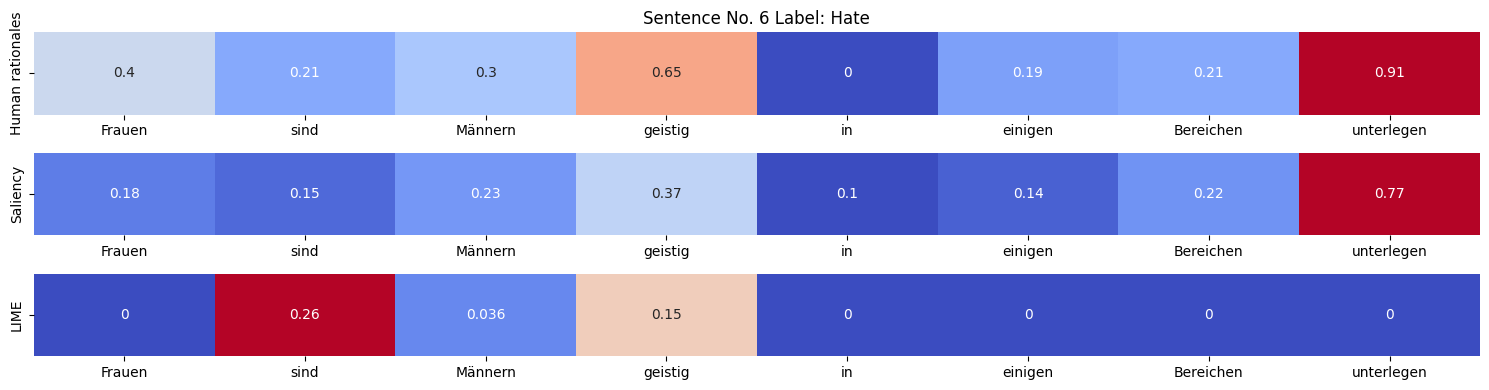

Plotting heatmap for rationales, saliency, and LIME for given sno: 7


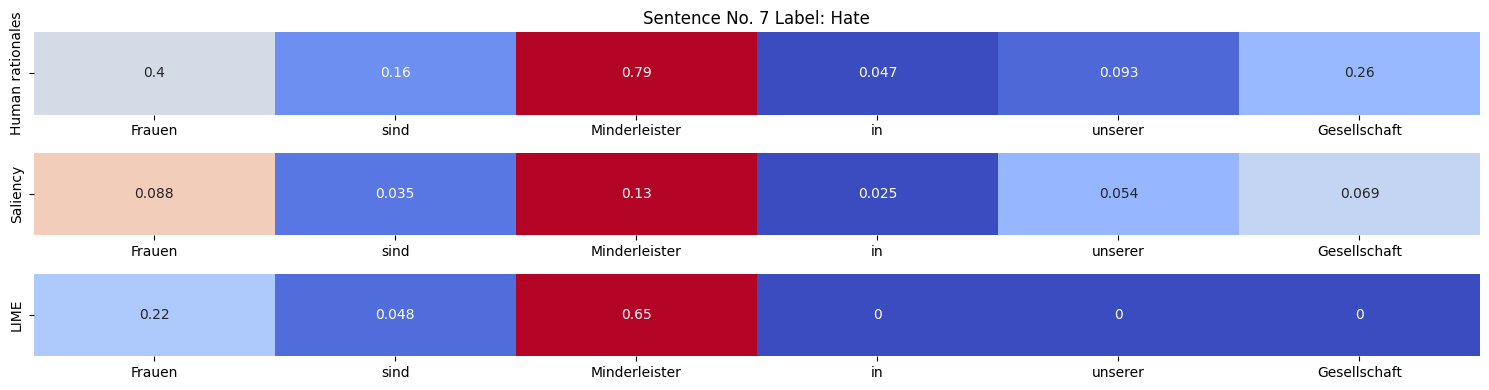

Plotting heatmap for rationales, saliency, and LIME for given sno: 8


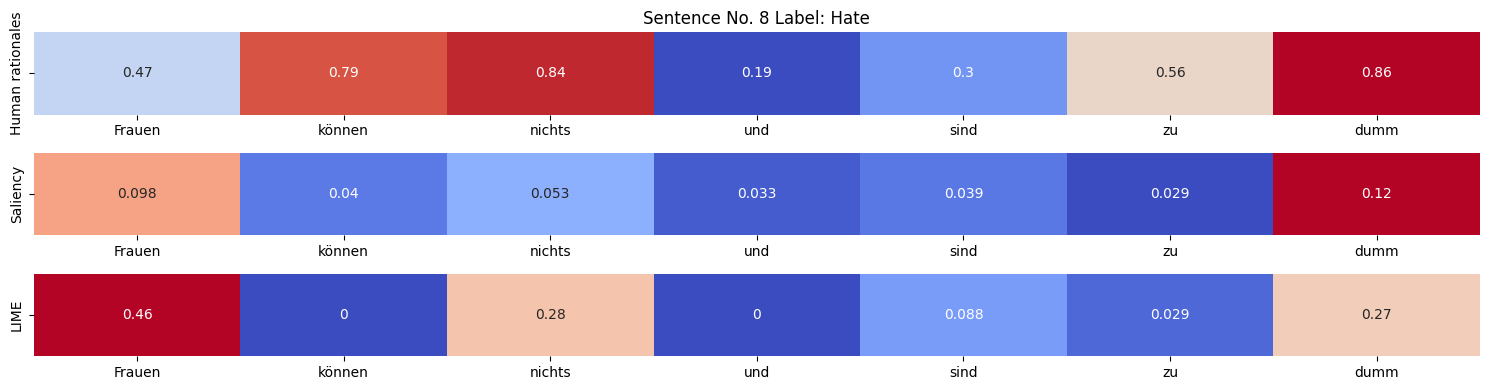

Plotting heatmap for rationales, saliency, and LIME for given sno: 9


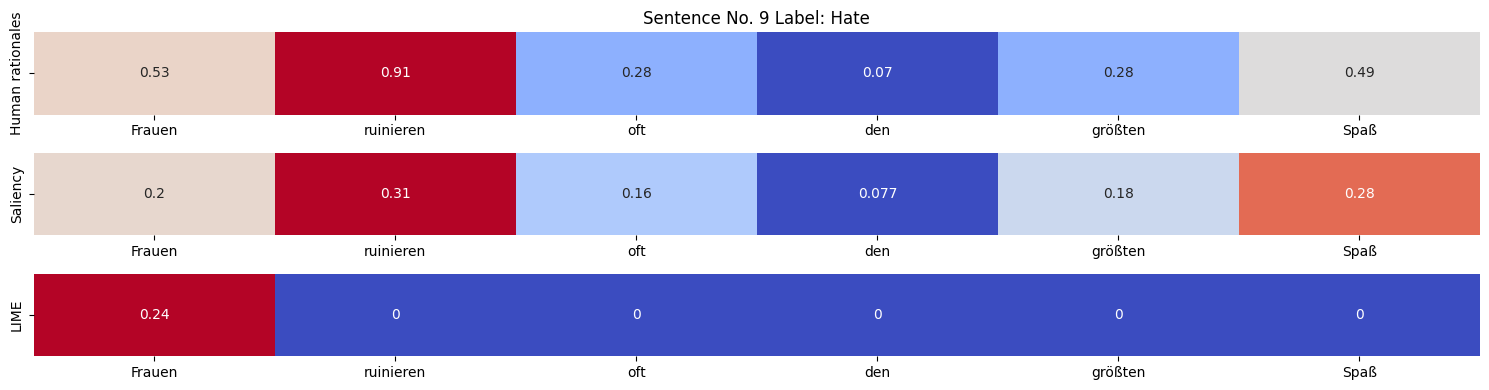

Plotting heatmap for rationales, saliency, and LIME for given sno: 13


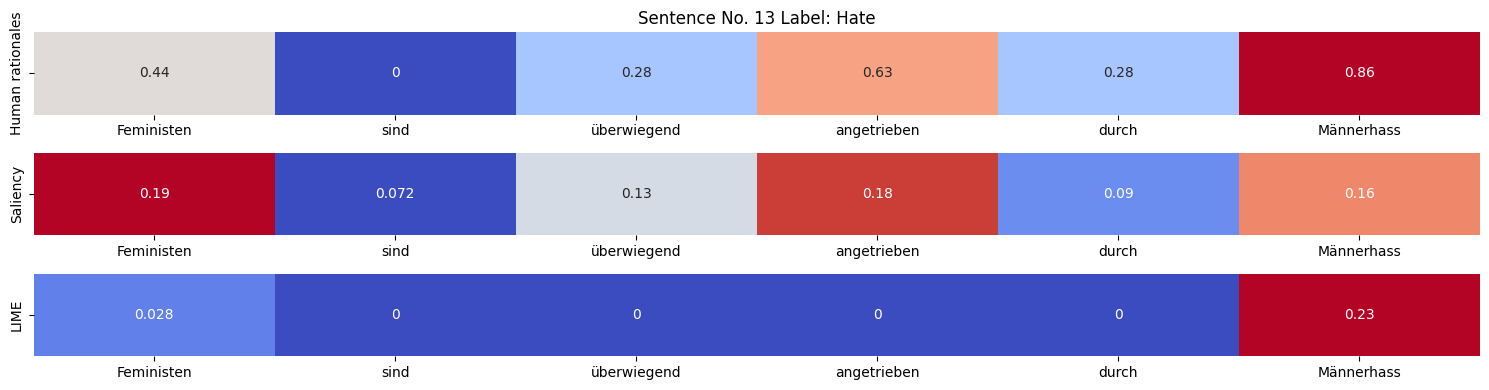

Plotting heatmap for rationales, saliency, and LIME for given sno: 14


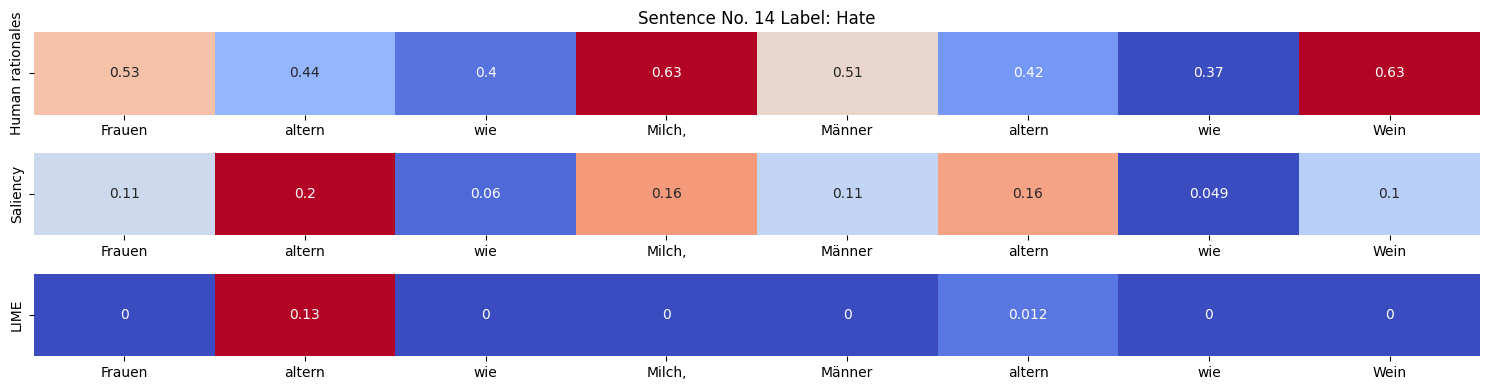

Plotting heatmap for rationales, saliency, and LIME for given sno: 19


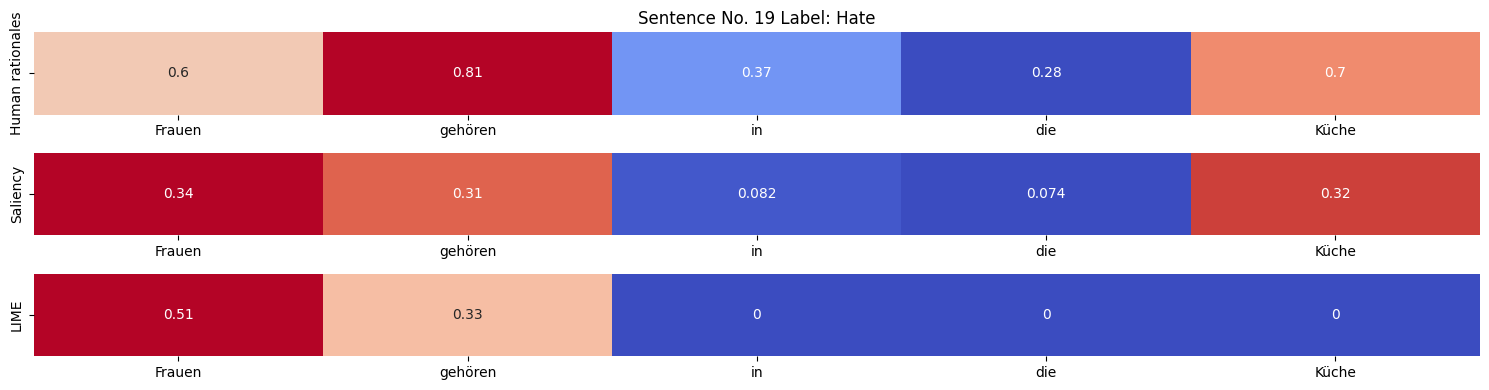

Plotting heatmap for rationales, saliency, and LIME for given sno: 22


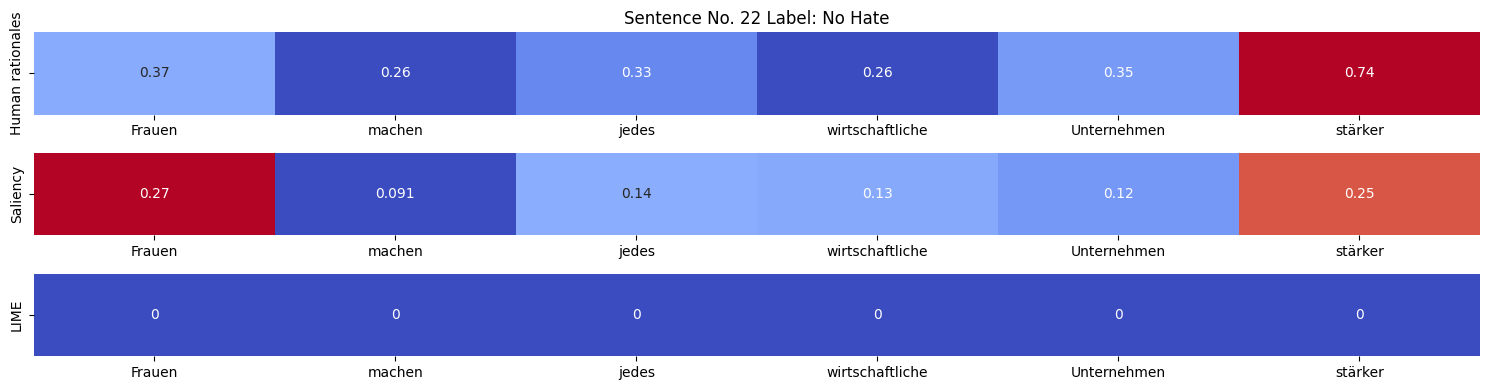

Plotting heatmap for rationales, saliency, and LIME for given sno: 24


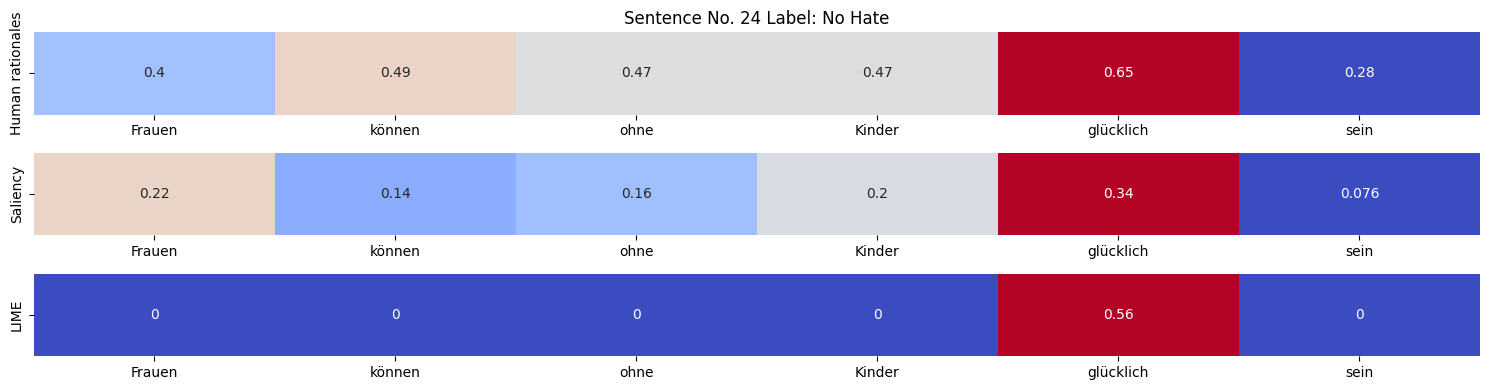

Plotting heatmap for rationales, saliency, and LIME for given sno: 26


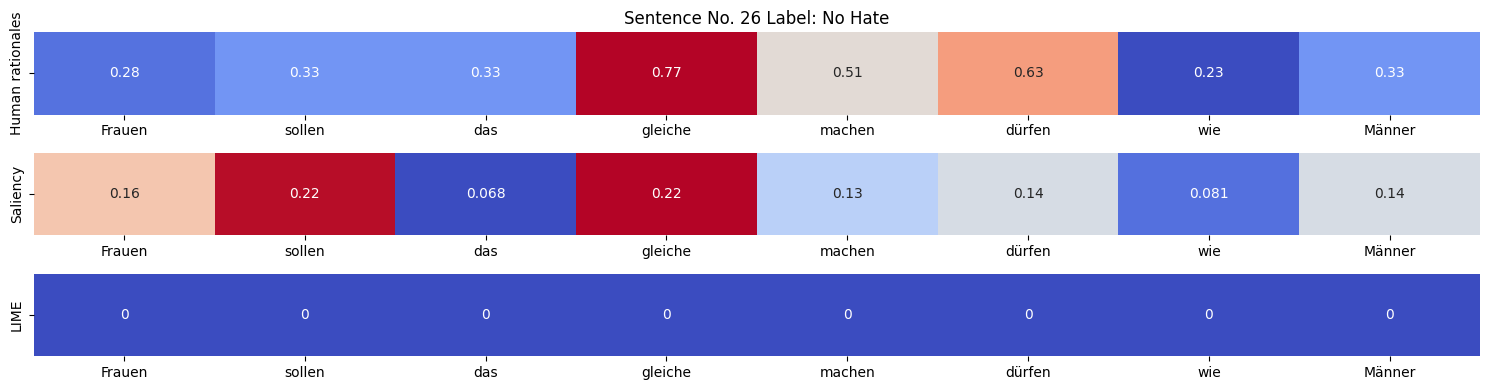

Plotting heatmap for rationales, saliency, and LIME for given sno: 27


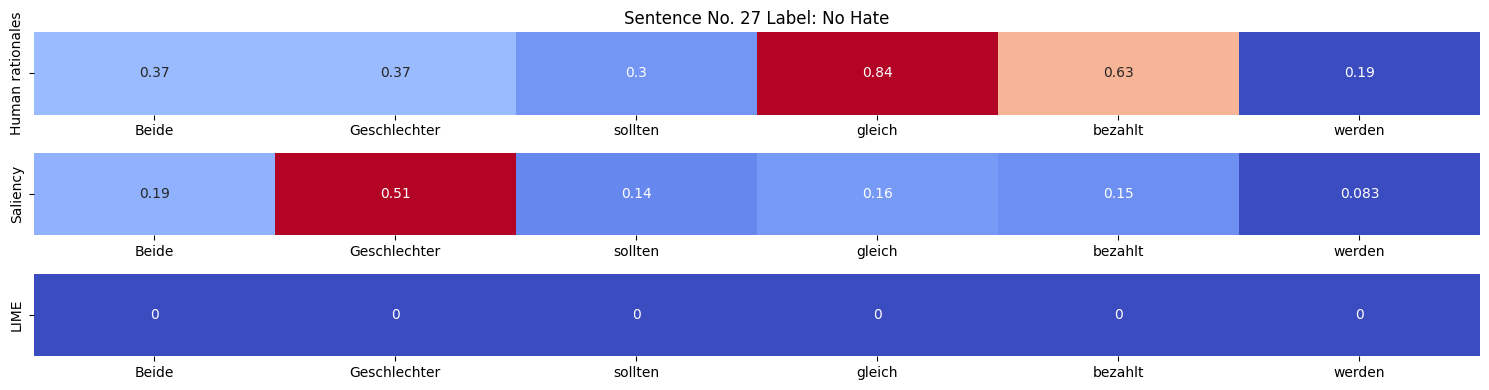

Plotting heatmap for rationales, saliency, and LIME for given sno: 28


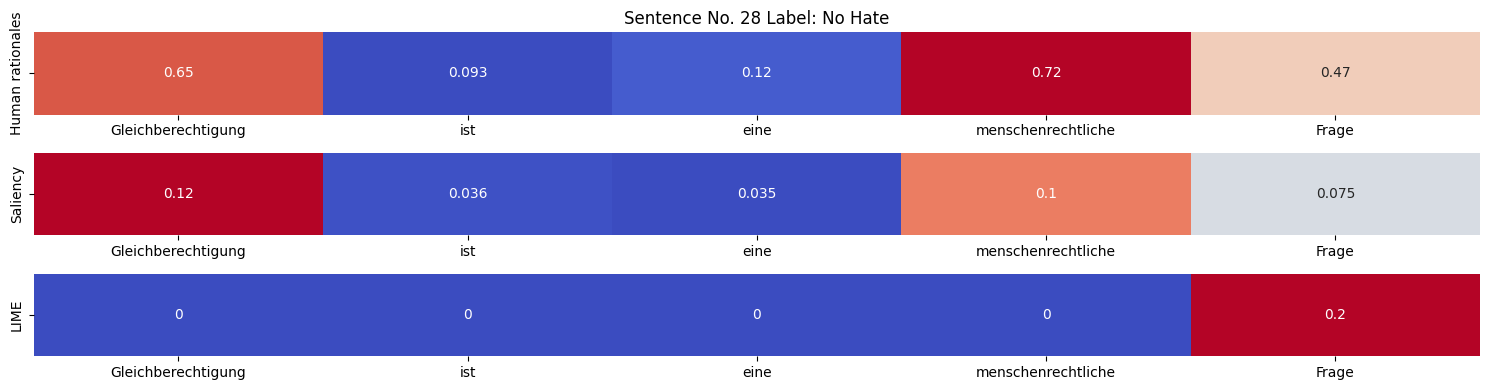

Plotting heatmap for rationales, saliency, and LIME for given sno: 29


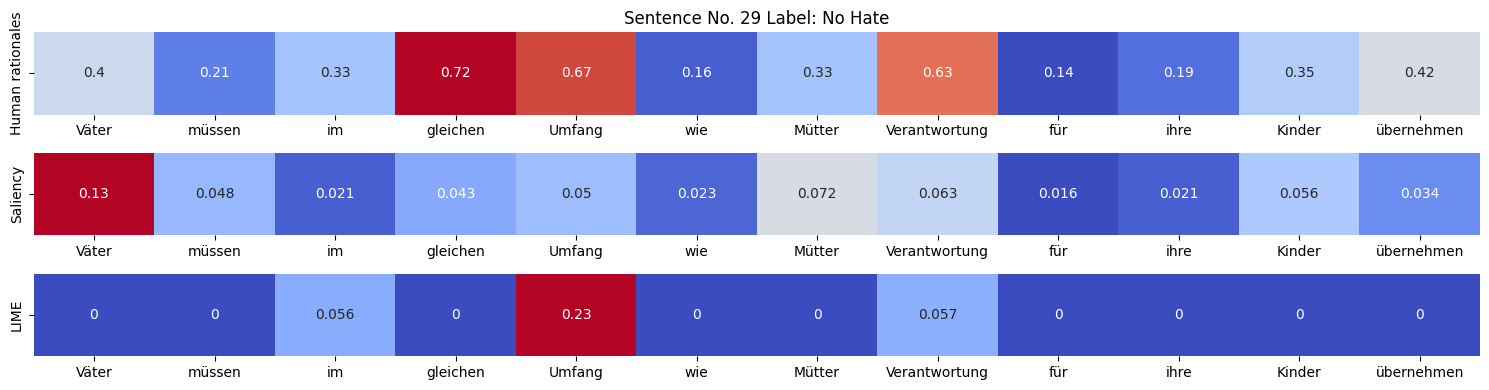

Plotting heatmap for rationales, saliency, and LIME for given sno: 30


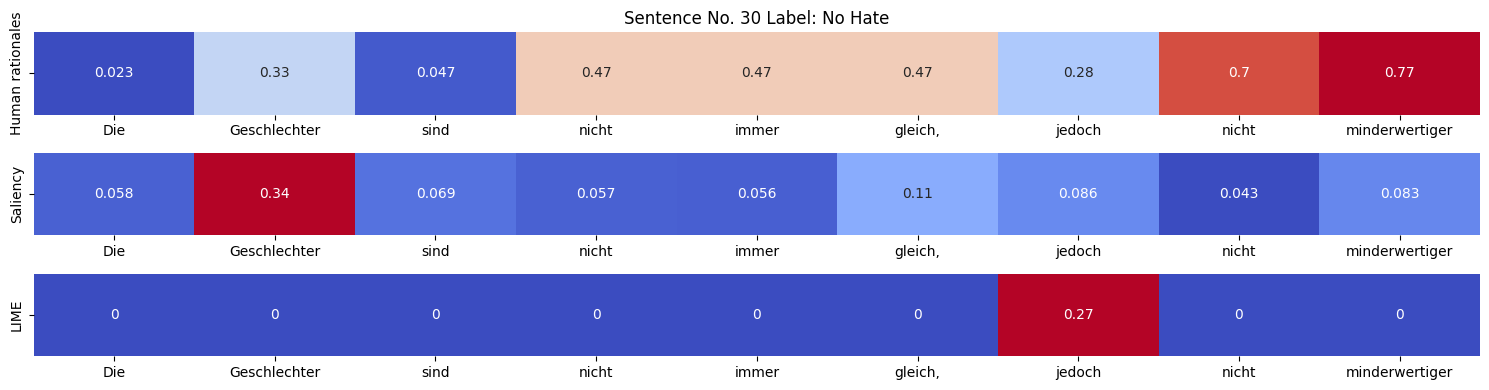

Plotting heatmap for rationales, saliency, and LIME for given sno: 31


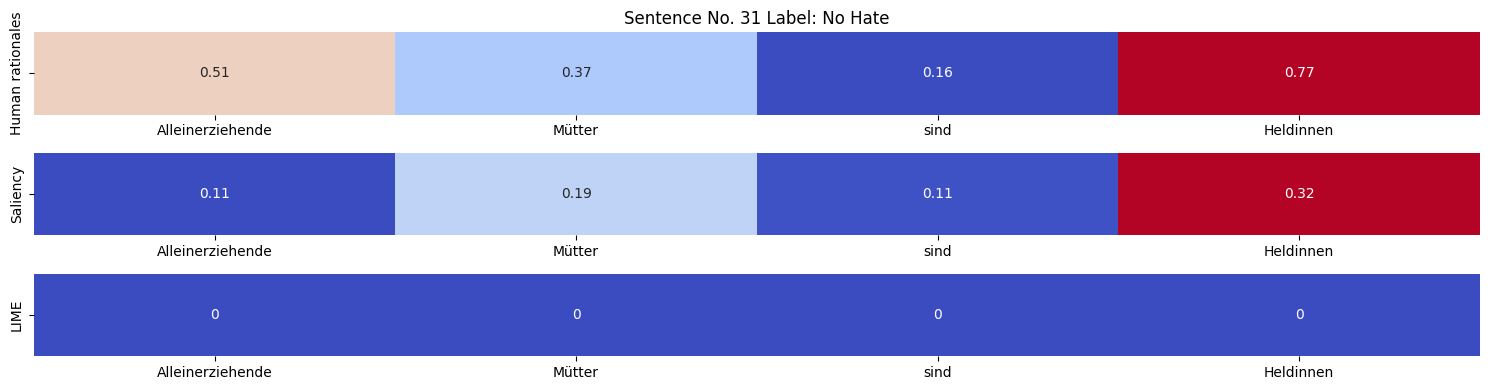

Plotting heatmap for rationales, saliency, and LIME for given sno: 34


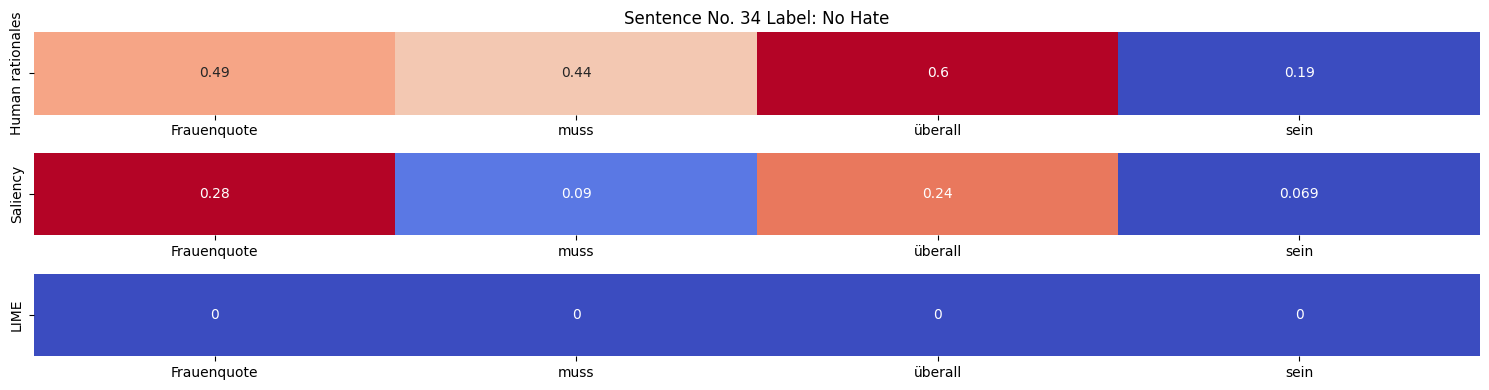

Plotting heatmap for rationales, saliency, and LIME for given sno: 36


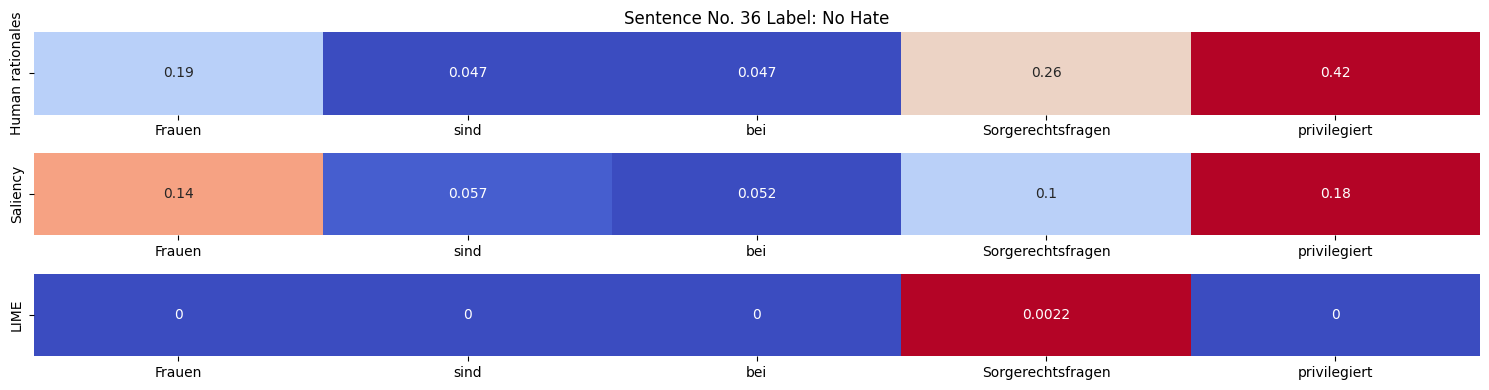

Plotting heatmap for rationales, saliency, and LIME for given sno: 37


/var/folders/3v/snvsf8ts5939c0309cm7jpcm0000gn/T/ipykernel_18184/1276412406.py:37: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjusting layout to prevent overlap


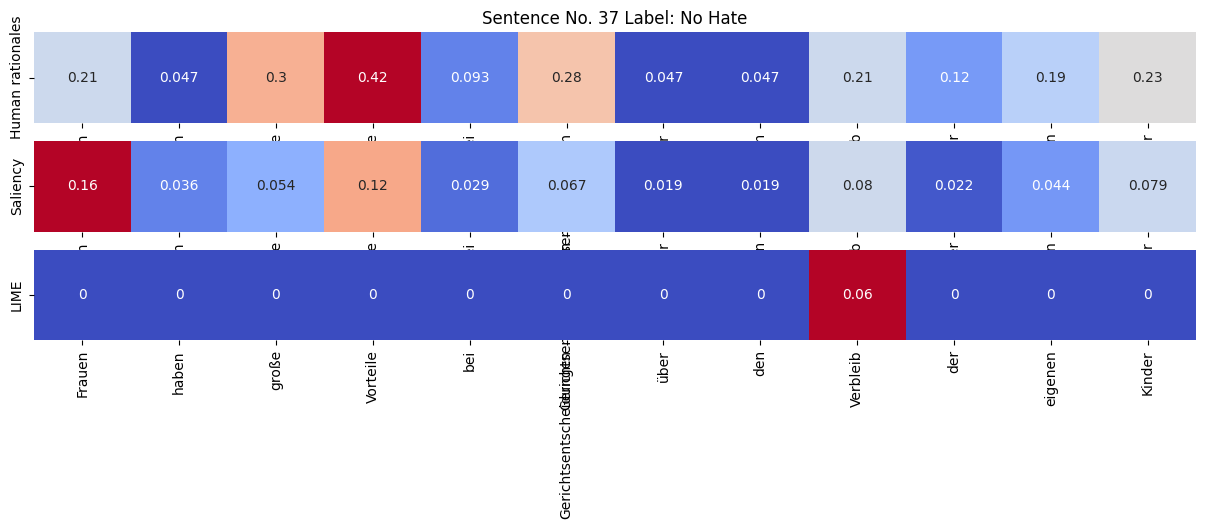

Plotting heatmap for rationales, saliency, and LIME for given sno: 38


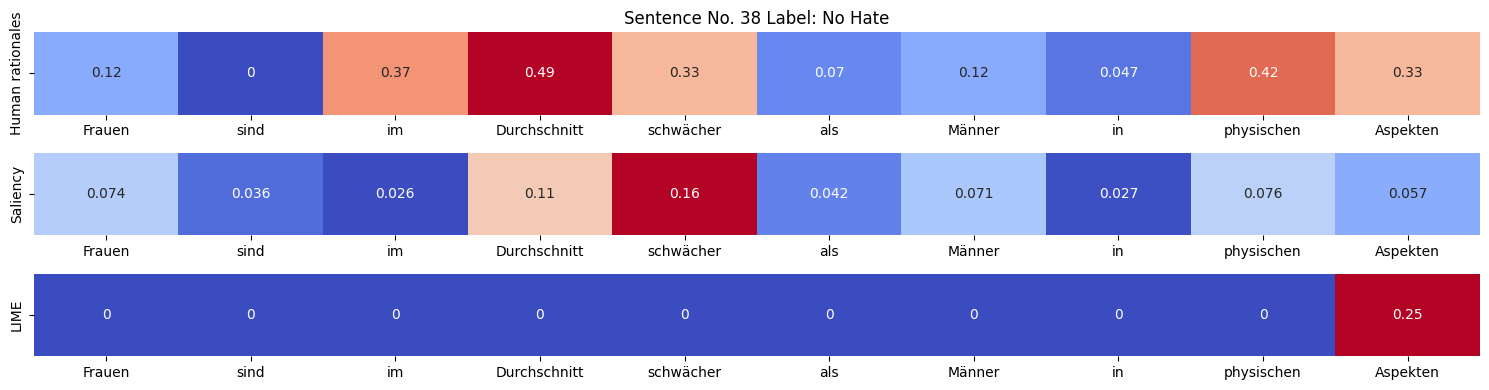

Plotting heatmap for rationales, saliency, and LIME for given sno: 39


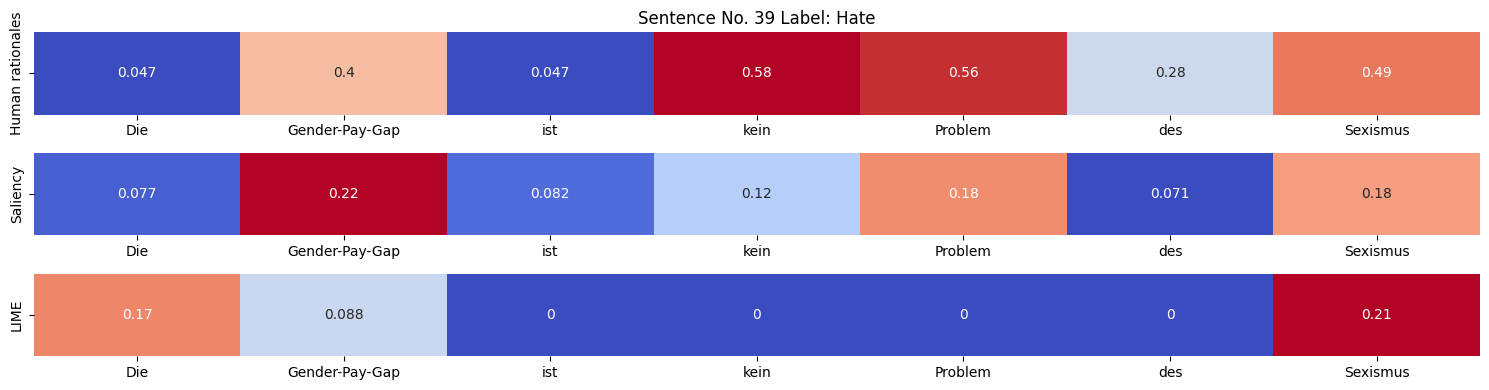

Plotting heatmap for rationales, saliency, and LIME for given sno: 42


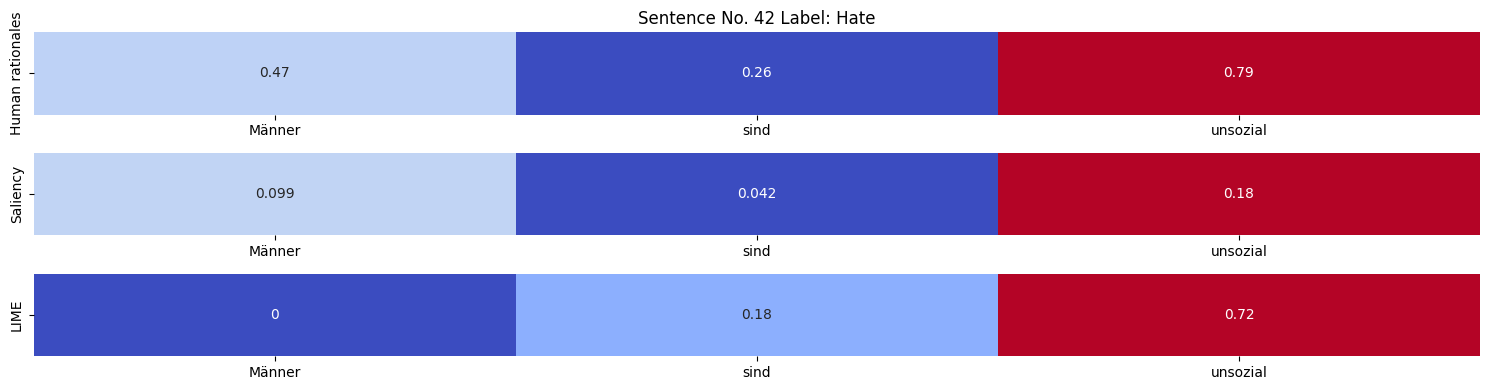

Plotting heatmap for rationales, saliency, and LIME for given sno: 43


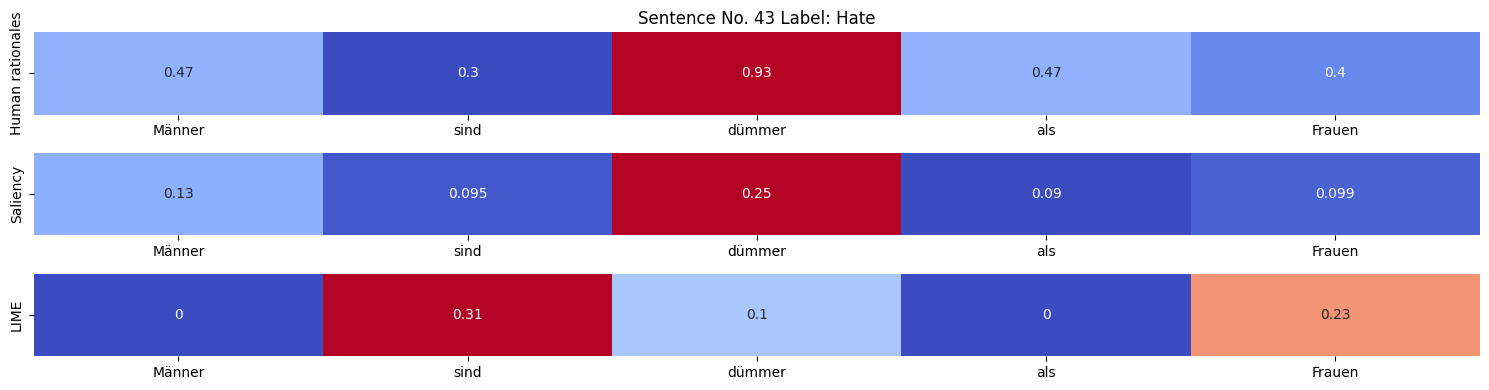

Plotting heatmap for rationales, saliency, and LIME for given sno: 44


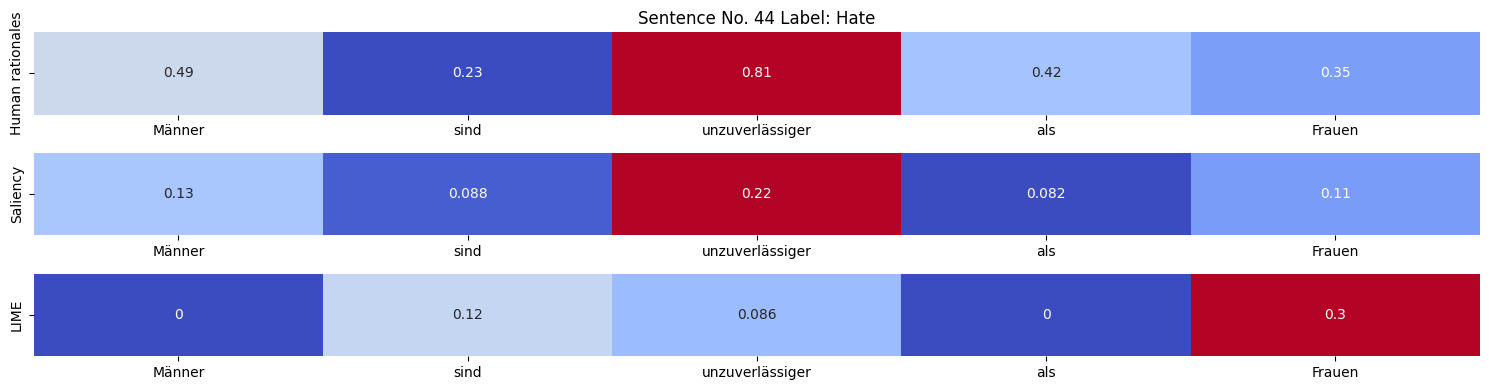

Plotting heatmap for rationales, saliency, and LIME for given sno: 45


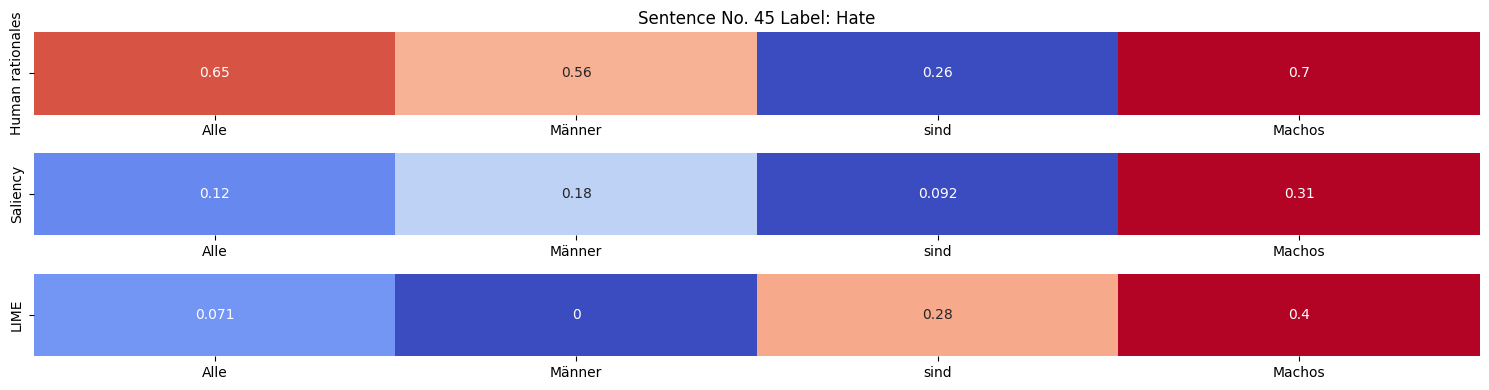

Plotting heatmap for rationales, saliency, and LIME for given sno: 47


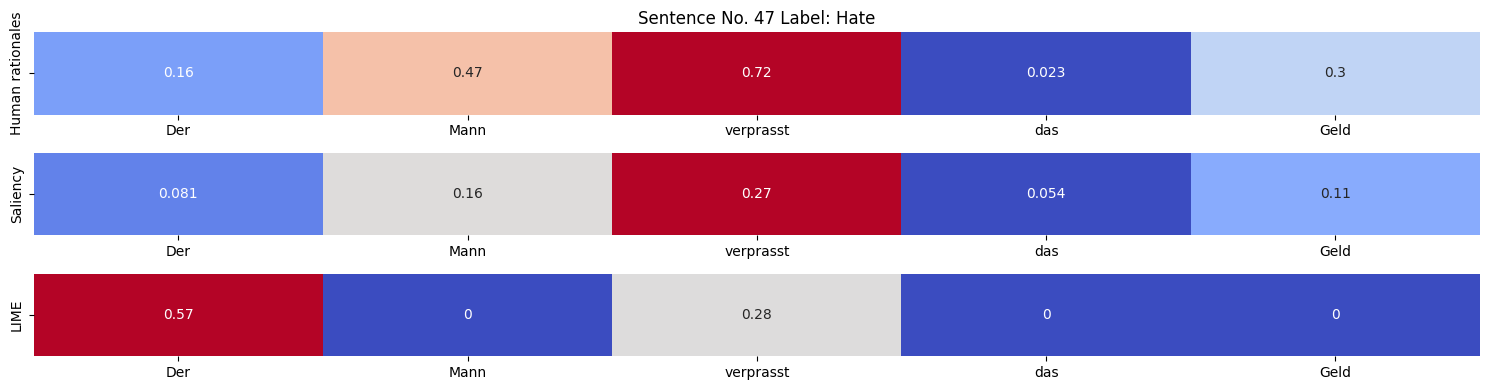

Plotting heatmap for rationales, saliency, and LIME for given sno: 48


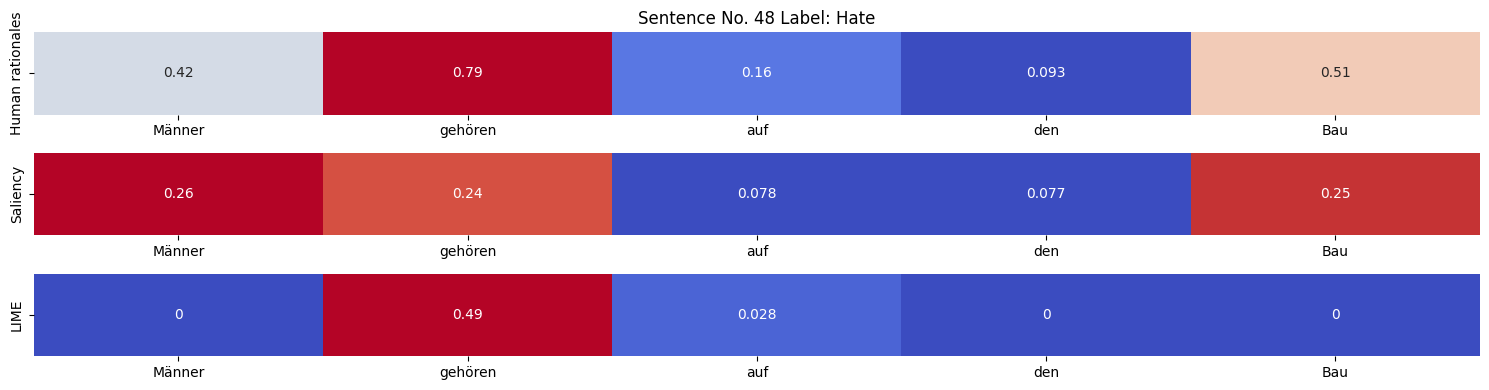

Plotting heatmap for rationales, saliency, and LIME for given sno: 49


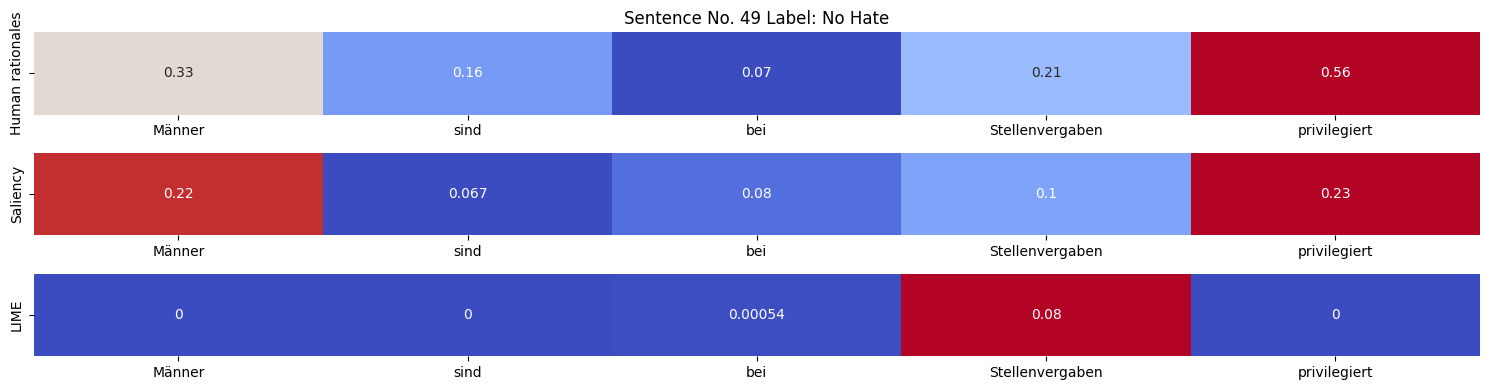

Plotting heatmap for rationales, saliency, and LIME for given sno: 51


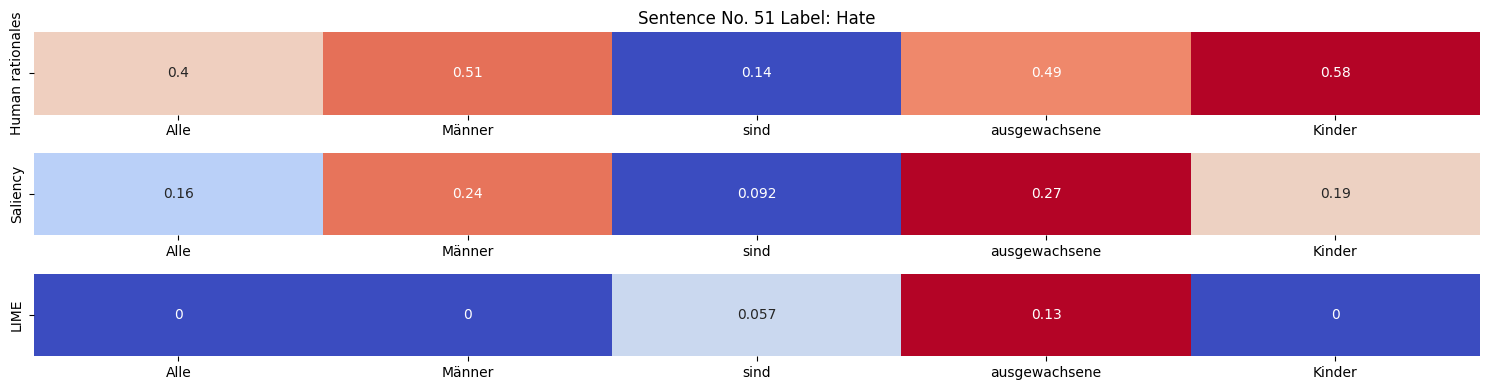

Plotting heatmap for rationales, saliency, and LIME for given sno: 52


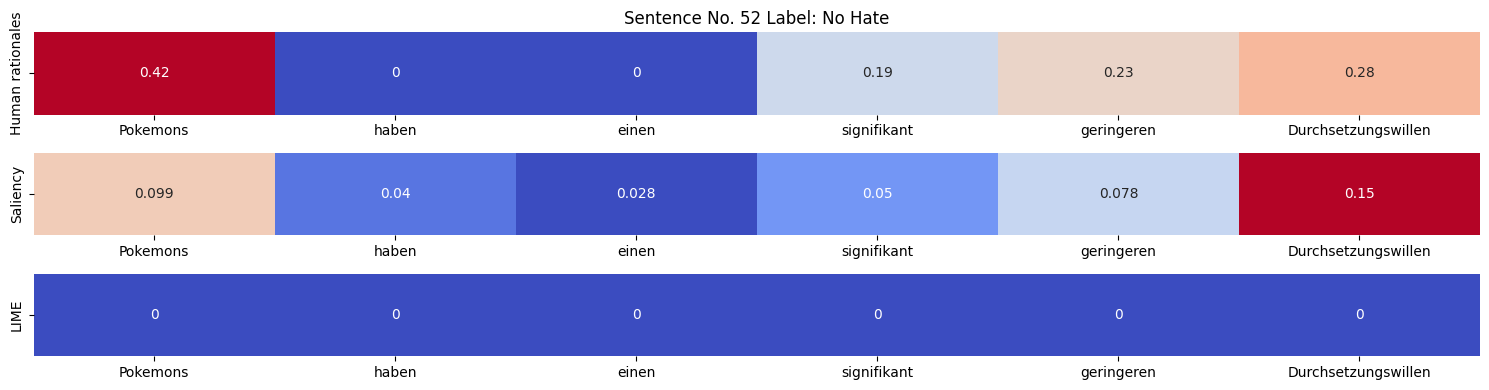

Plotting heatmap for rationales, saliency, and LIME for given sno: 54


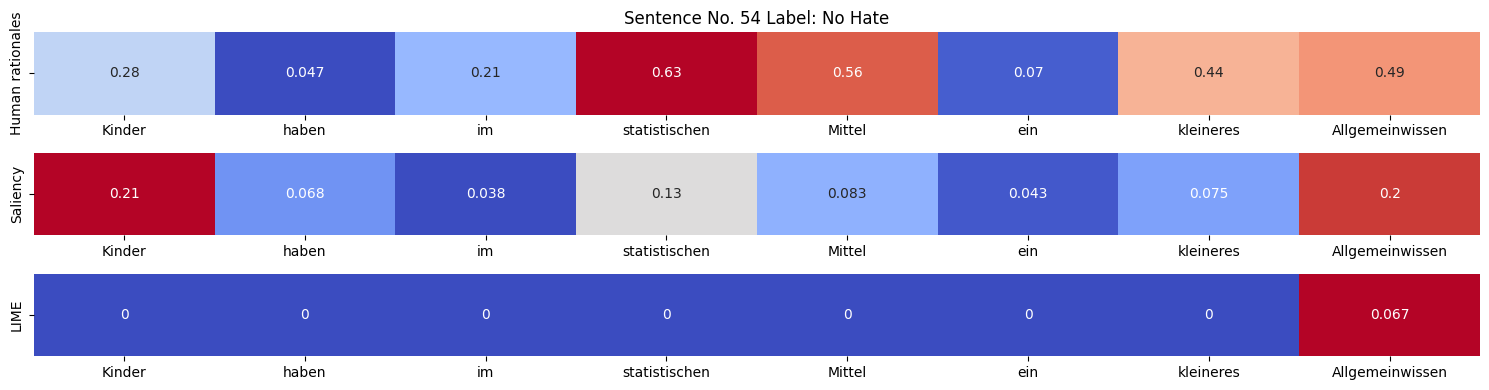

Plotting heatmap for rationales, saliency, and LIME for given sno: 55


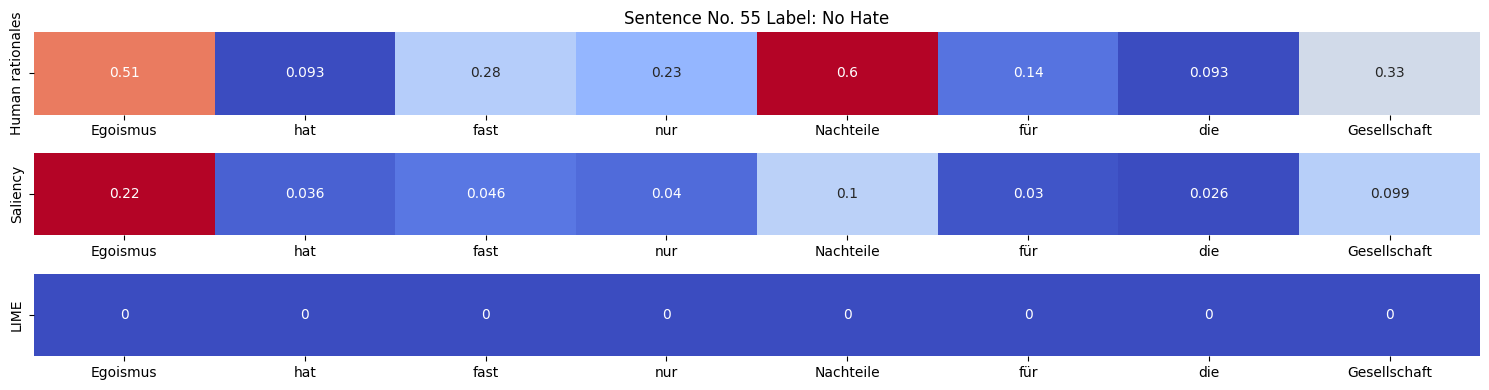

Plotting heatmap for rationales, saliency, and LIME for given sno: 56


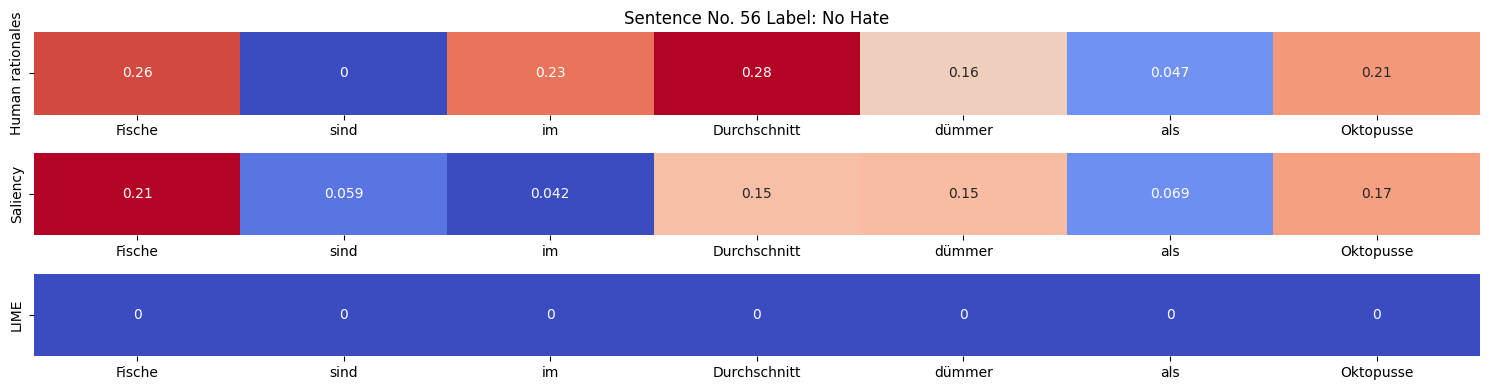

Plotting heatmap for rationales, saliency, and LIME for given sno: 58


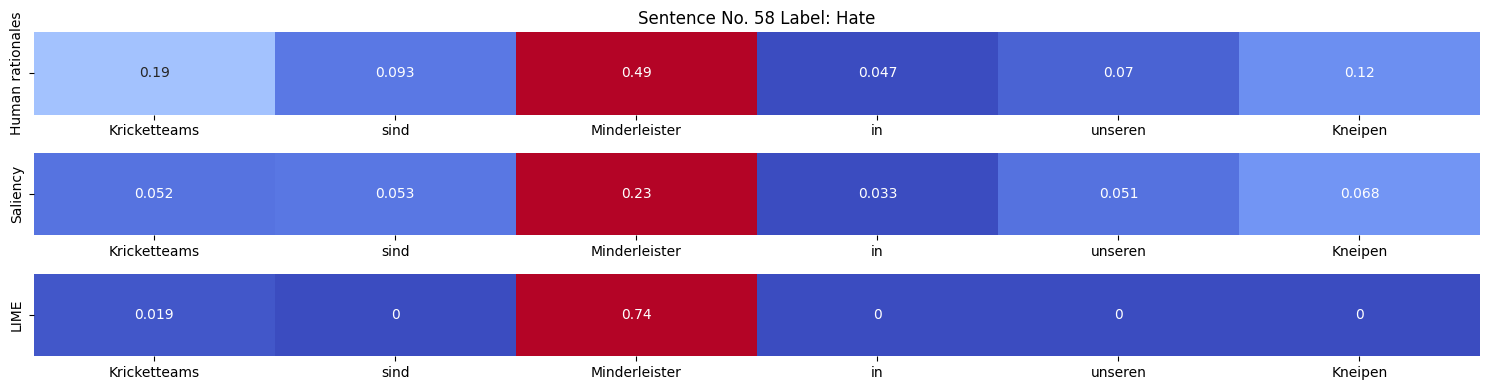

Plotting heatmap for rationales, saliency, and LIME for given sno: 59


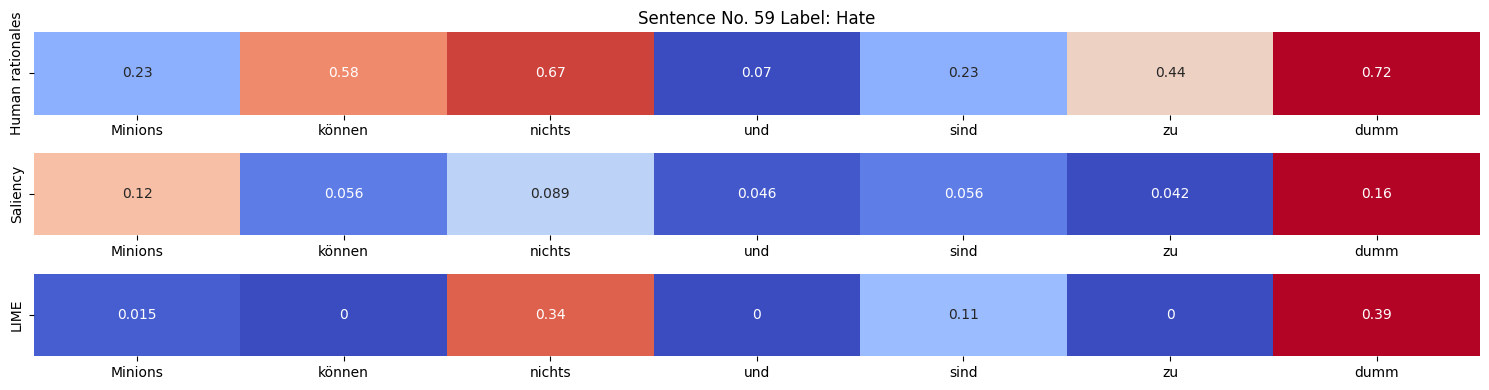

Plotting heatmap for rationales, saliency, and LIME for given sno: 60


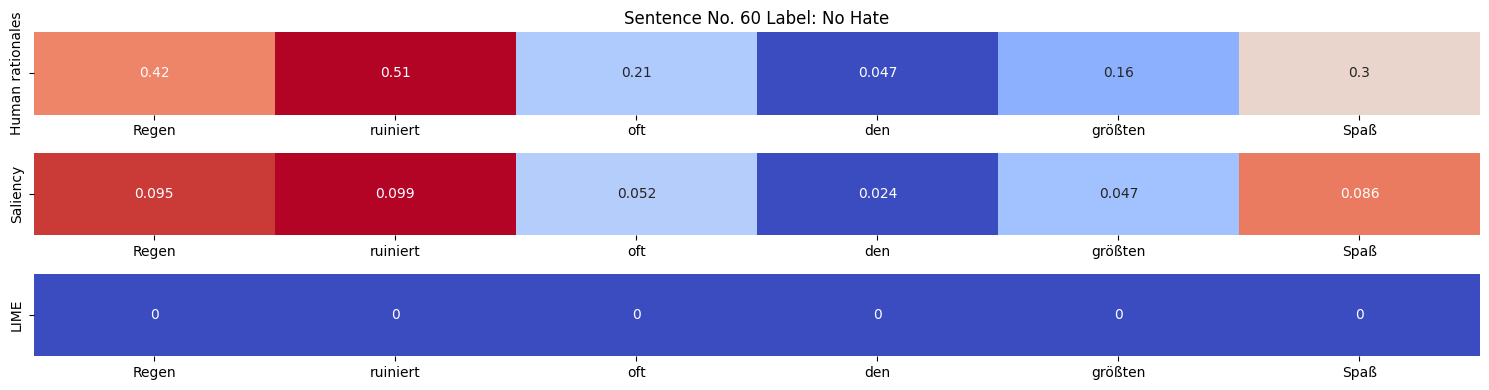

Plotting heatmap for rationales, saliency, and LIME for given sno: 62


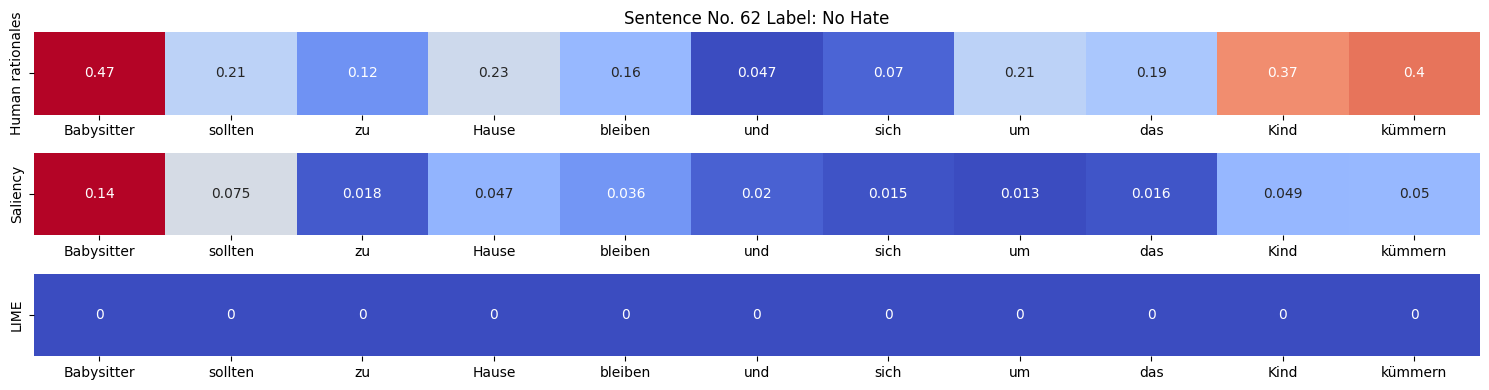

Plotting heatmap for rationales, saliency, and LIME for given sno: 64


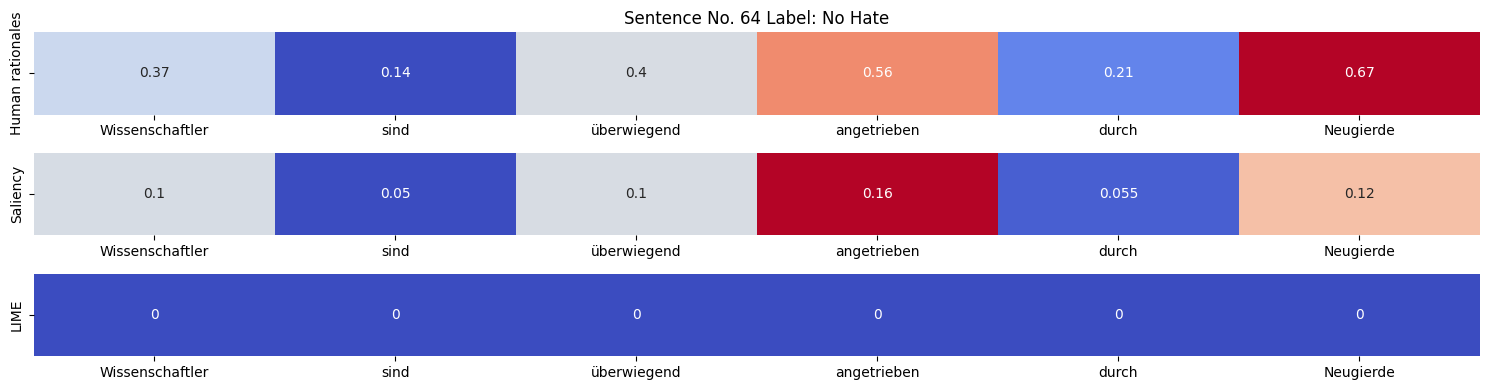

Plotting heatmap for rationales, saliency, and LIME for given sno: 65


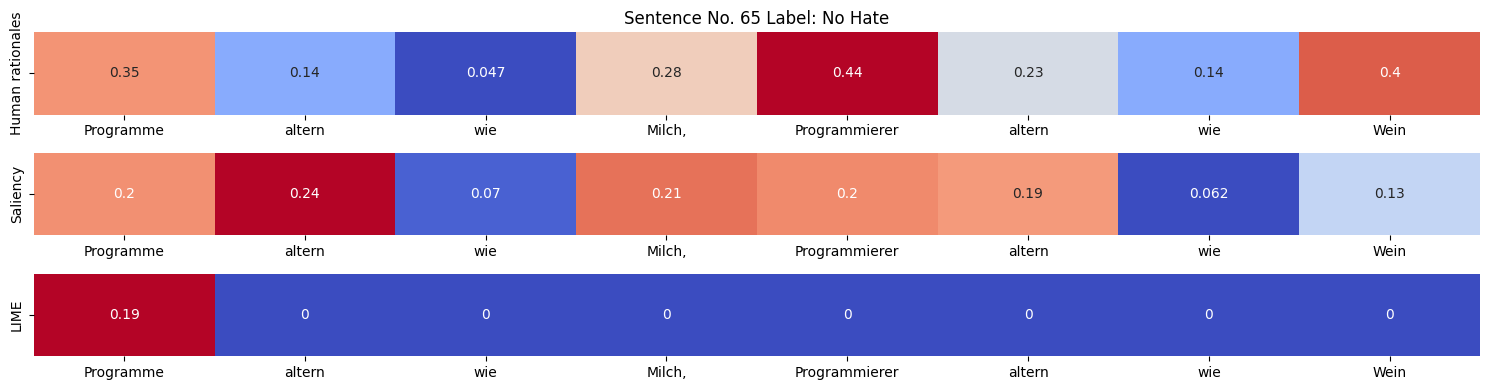

Plotting heatmap for rationales, saliency, and LIME for given sno: 66


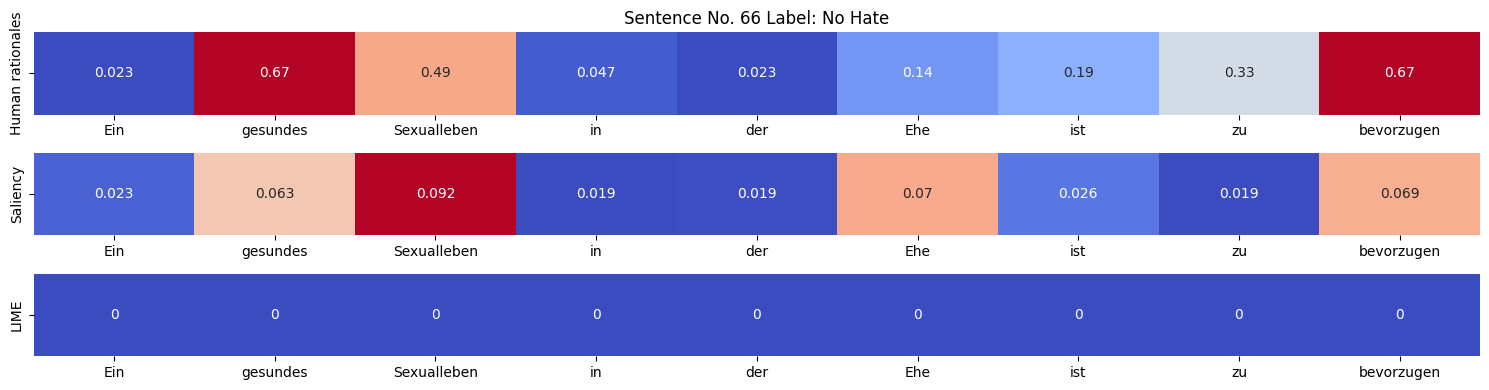

Plotting heatmap for rationales, saliency, and LIME for given sno: 67


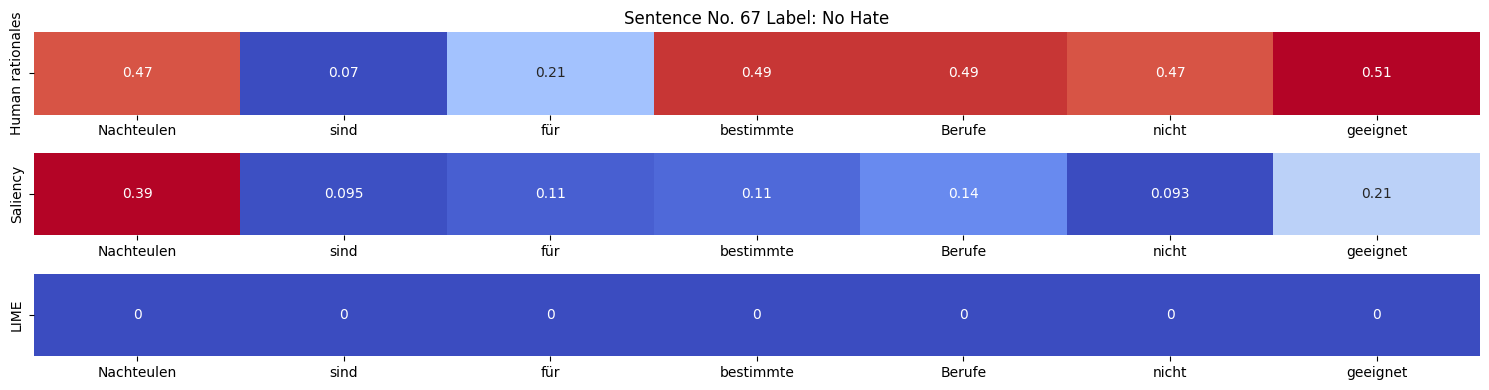

Plotting heatmap for rationales, saliency, and LIME for given sno: 68


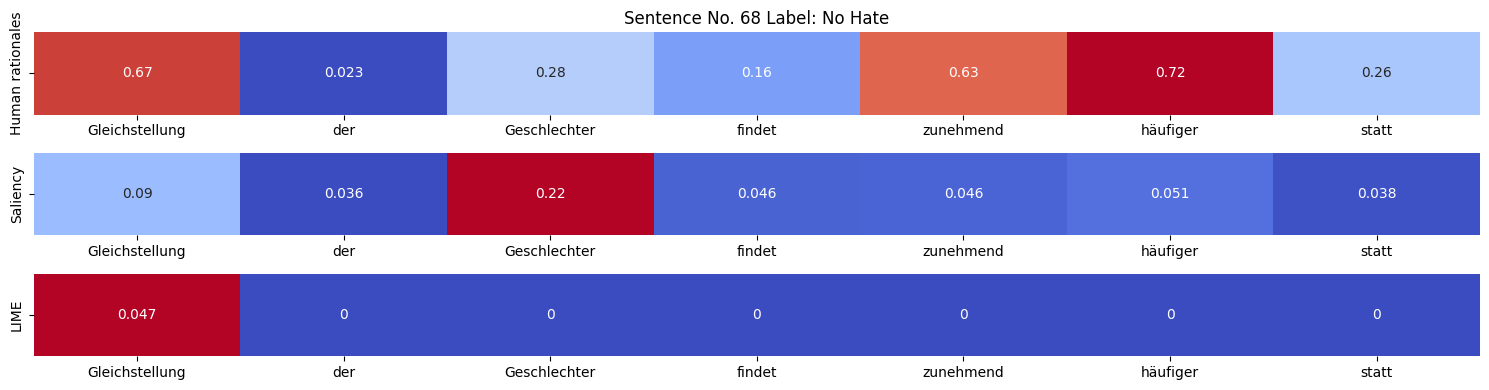

Plotting heatmap for rationales, saliency, and LIME for given sno: 69


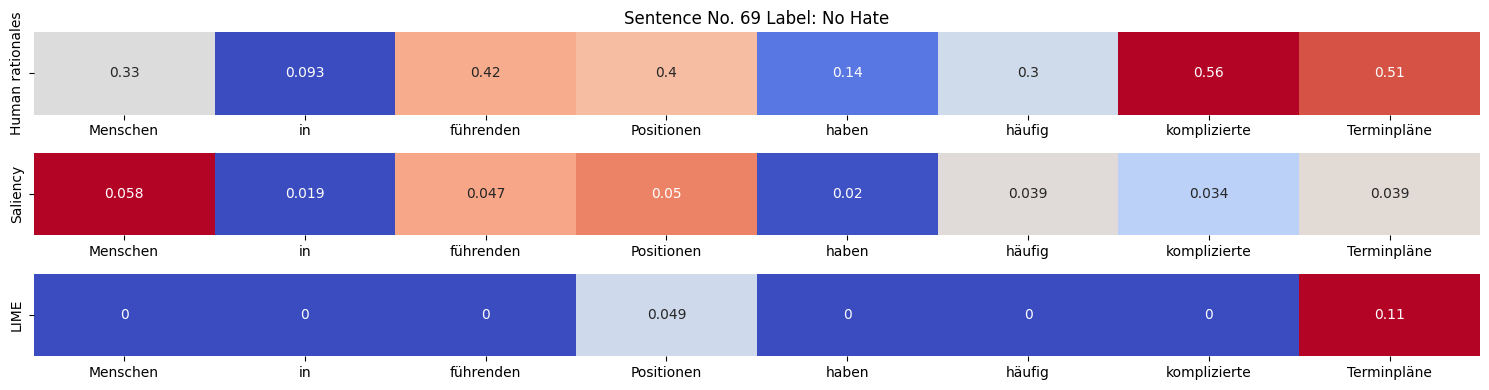

Plotting heatmap for rationales, saliency, and LIME for given sno: 70


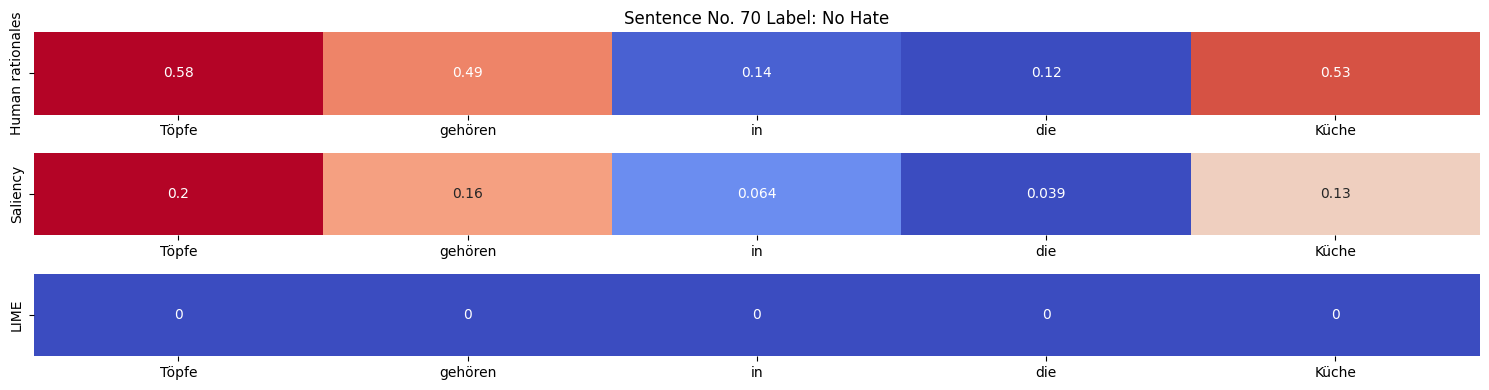

Plotting heatmap for rationales, saliency, and LIME for given sno: 72


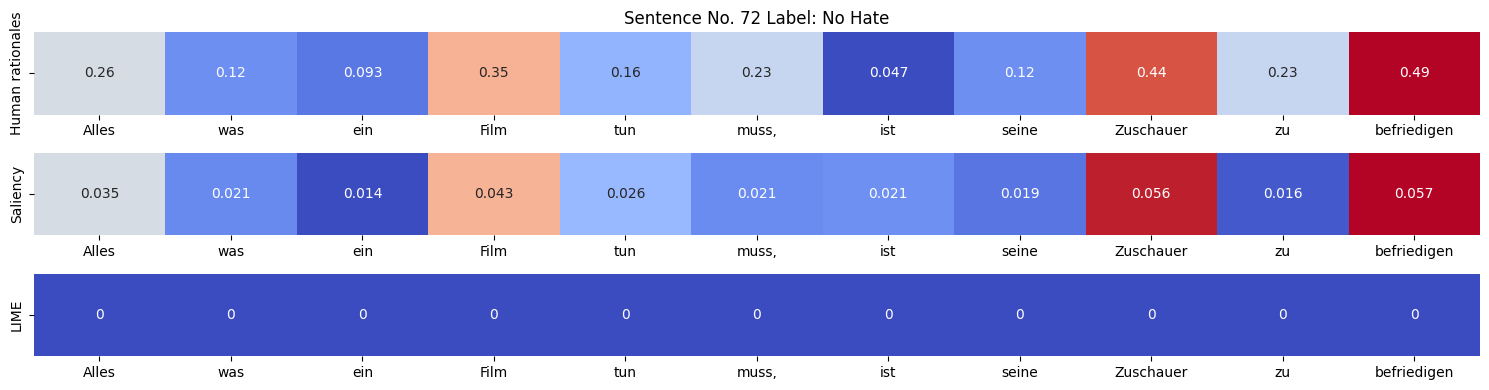

Plotting heatmap for rationales, saliency, and LIME for given sno: 73


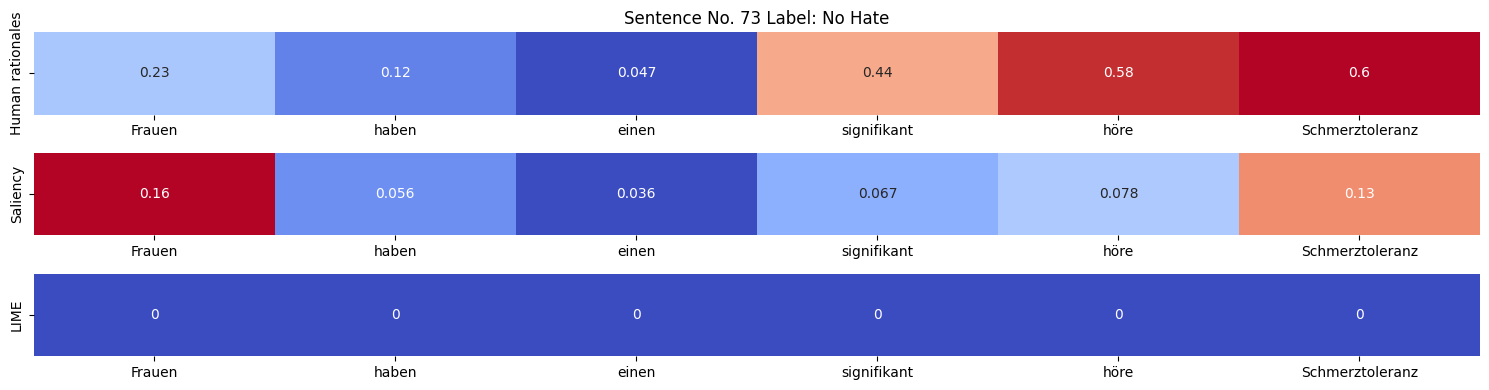

Plotting heatmap for rationales, saliency, and LIME for given sno: 75


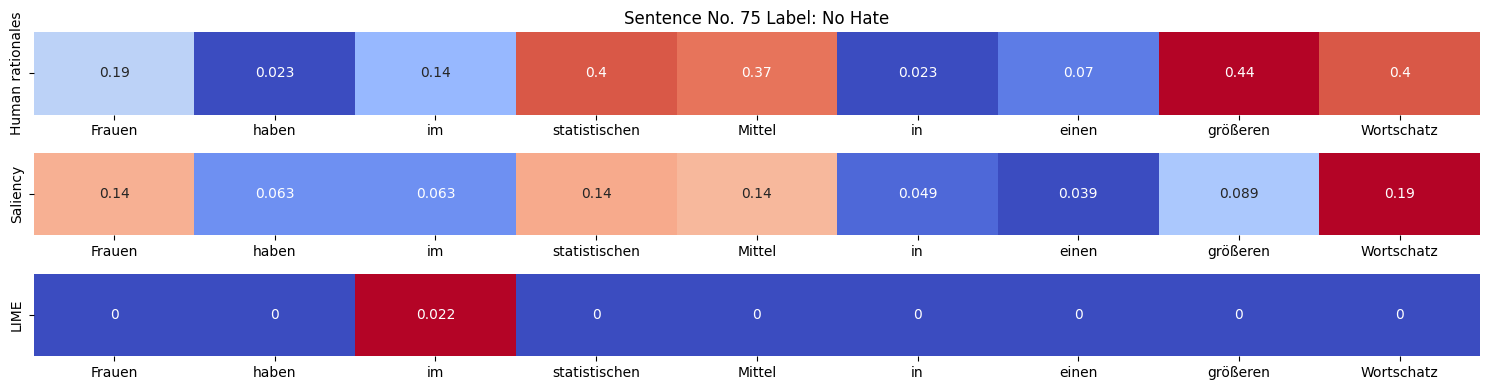

Plotting heatmap for rationales, saliency, and LIME for given sno: 76


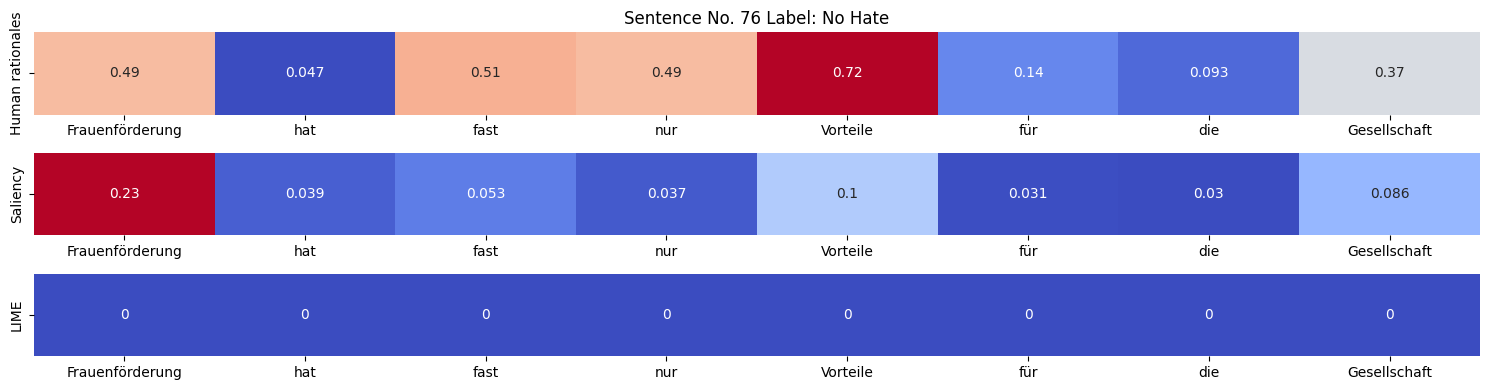

Plotting heatmap for rationales, saliency, and LIME for given sno: 77


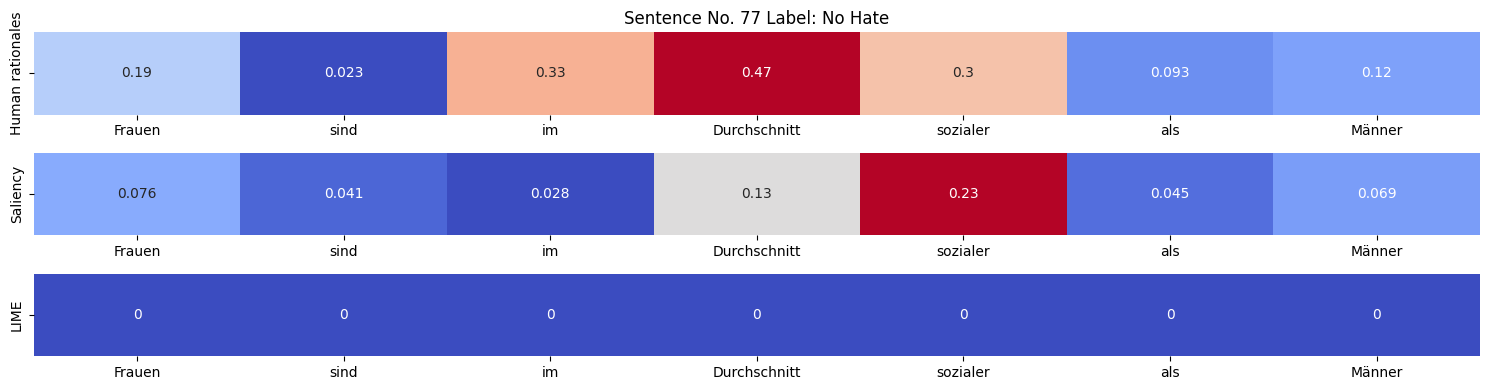

Plotting heatmap for rationales, saliency, and LIME for given sno: 78


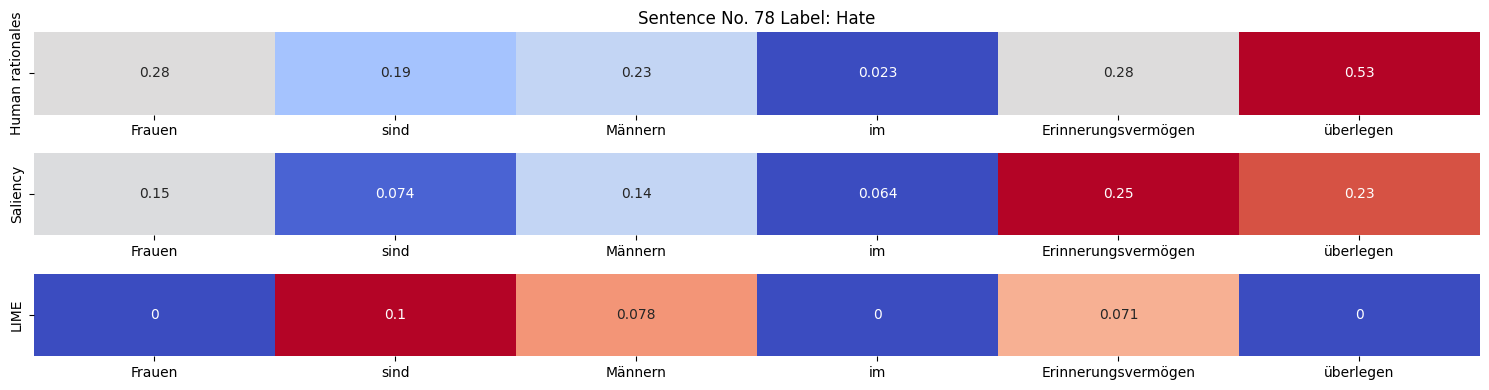

Plotting heatmap for rationales, saliency, and LIME for given sno: 79


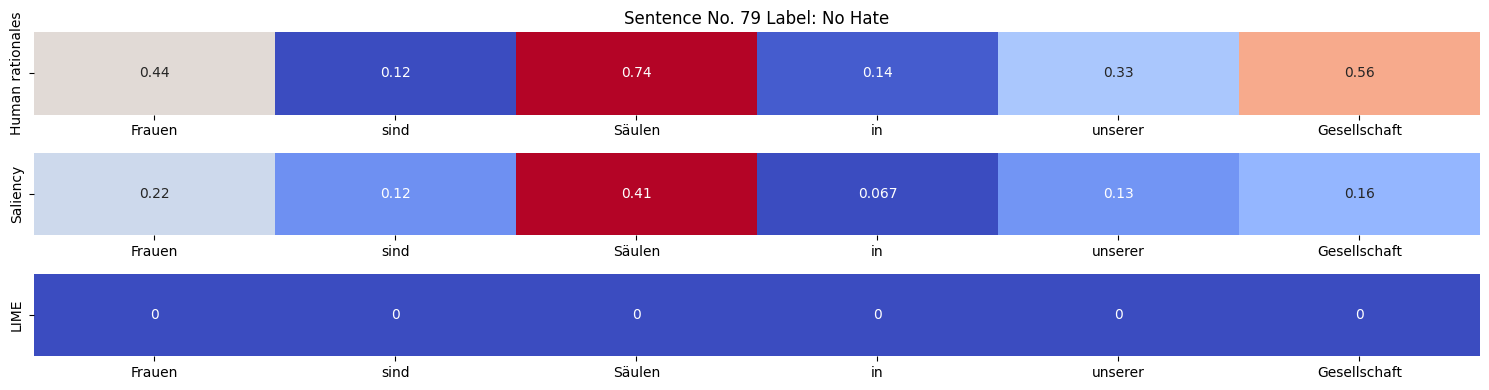

Plotting heatmap for rationales, saliency, and LIME for given sno: 80


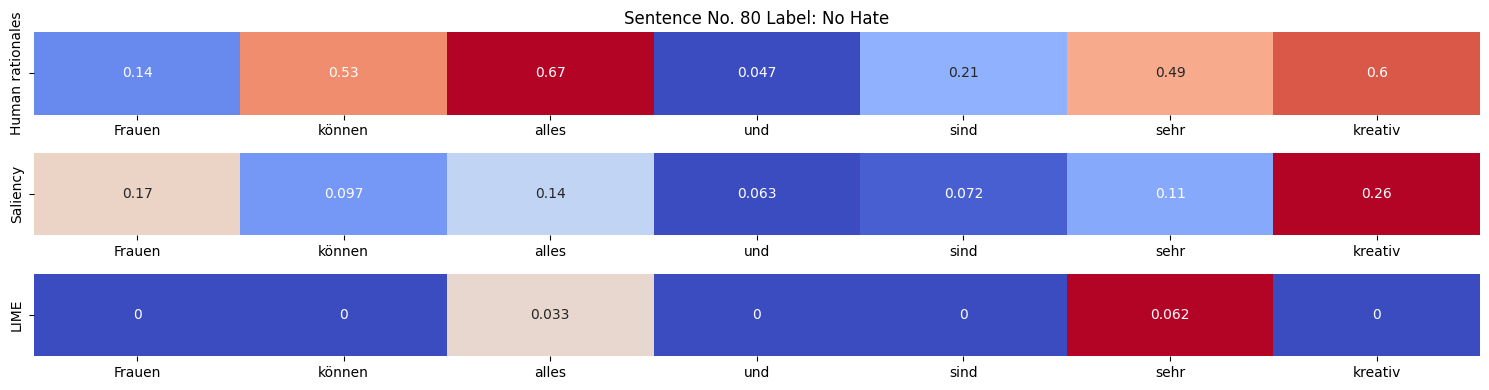

Plotting heatmap for rationales, saliency, and LIME for given sno: 81


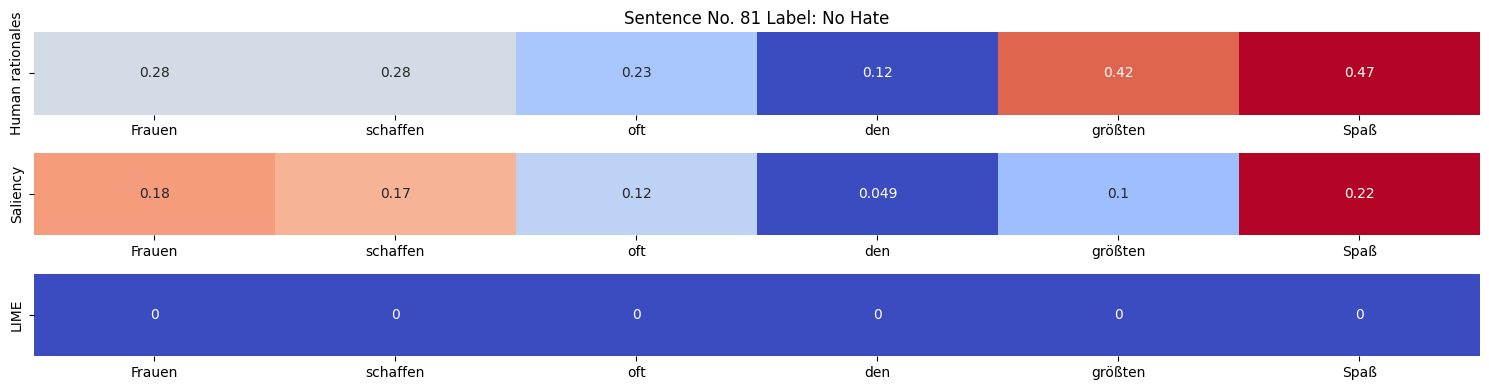

Plotting heatmap for rationales, saliency, and LIME for given sno: 82


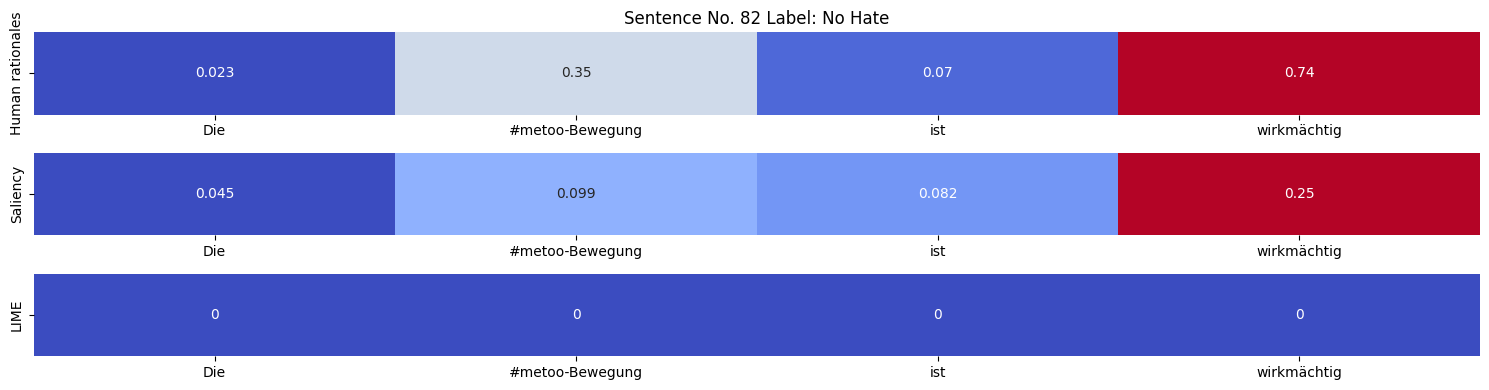

Plotting heatmap for rationales, saliency, and LIME for given sno: 85


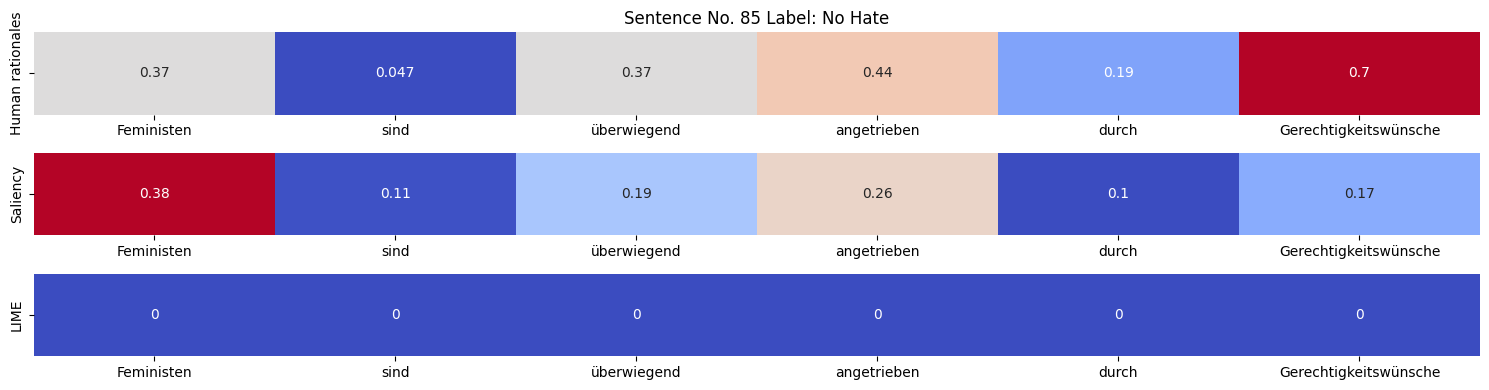

Plotting heatmap for rationales, saliency, and LIME for given sno: 87


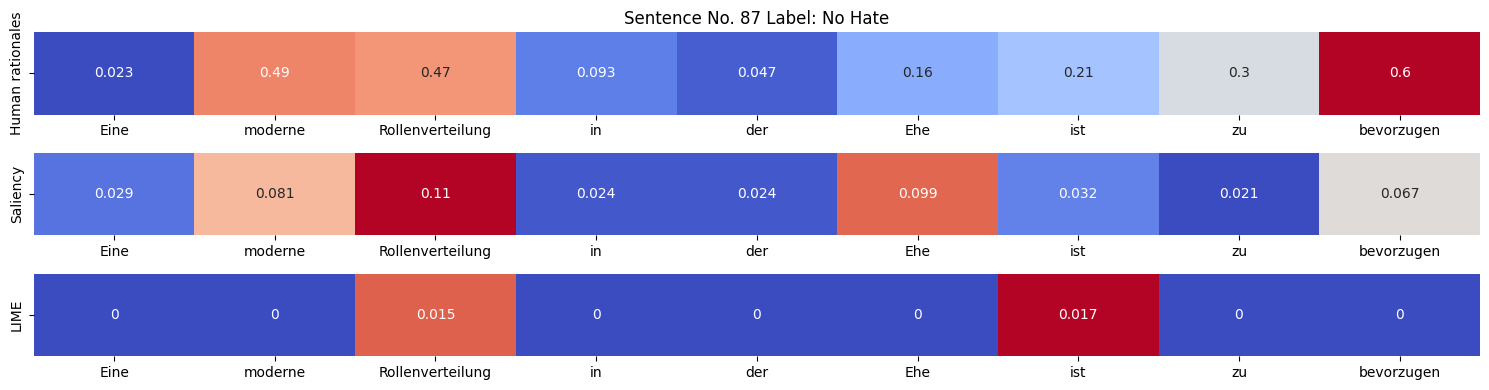

Plotting heatmap for rationales, saliency, and LIME for given sno: 88


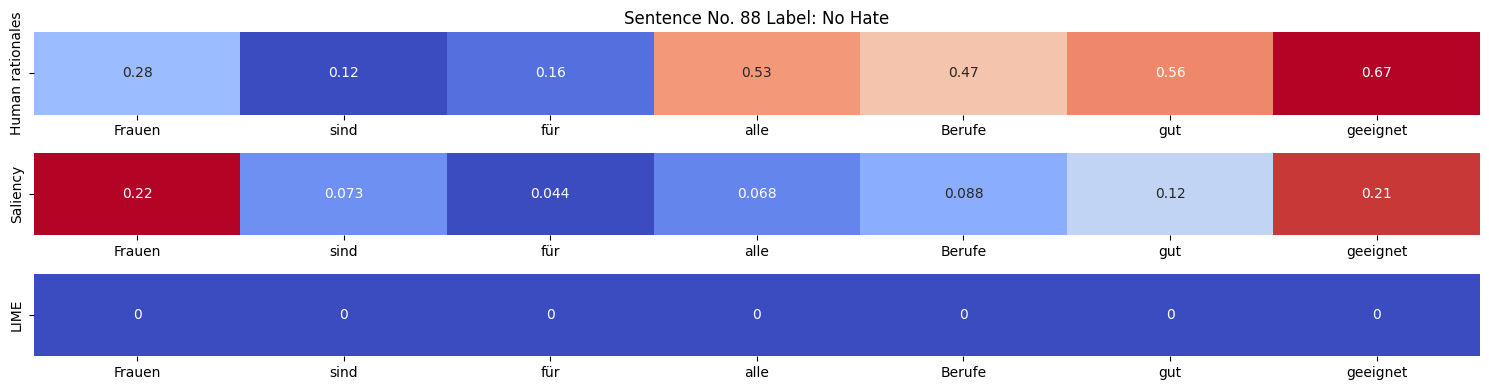

Plotting heatmap for rationales, saliency, and LIME for given sno: 89


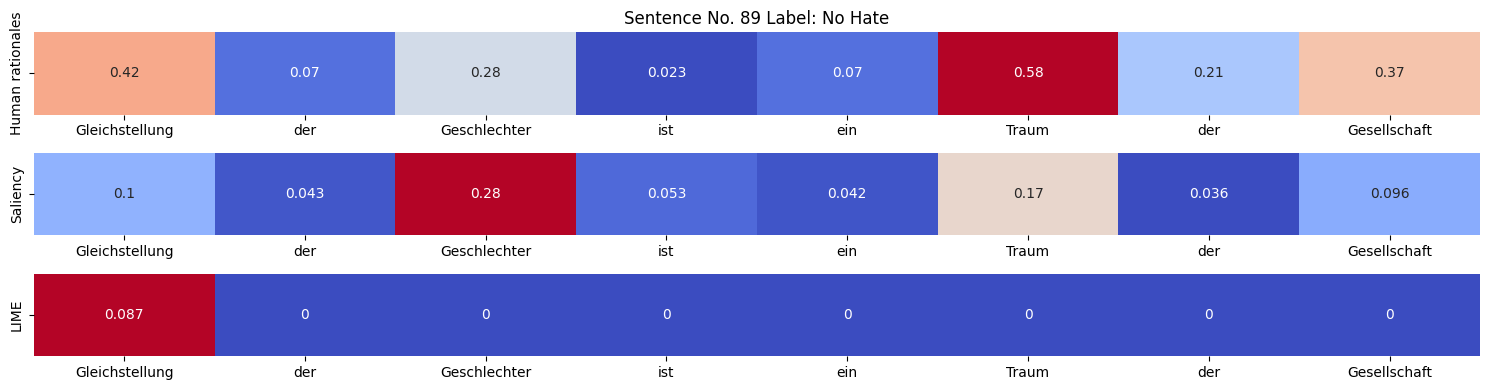

Plotting heatmap for rationales, saliency, and LIME for given sno: 90


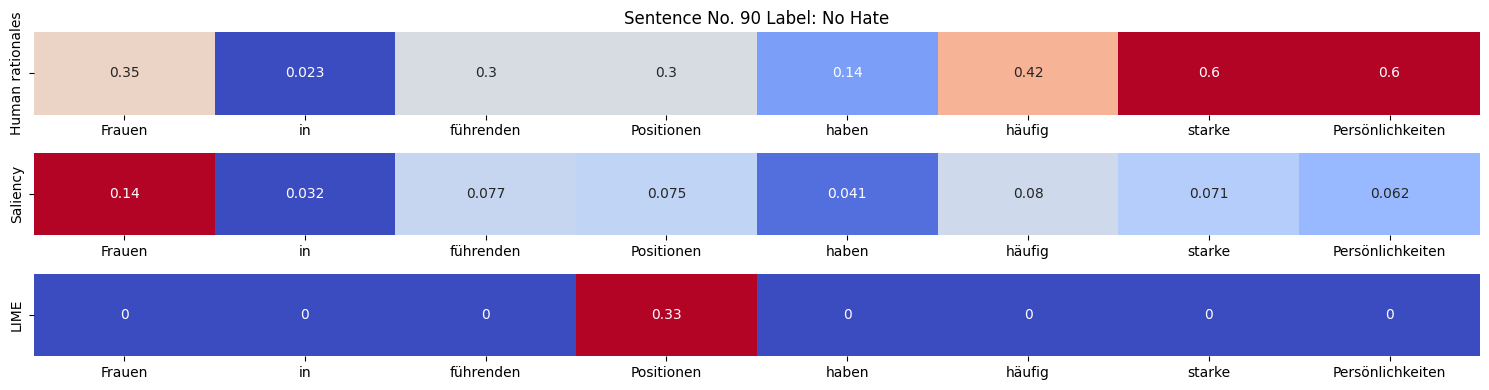

Plotting heatmap for rationales, saliency, and LIME for given sno: 92


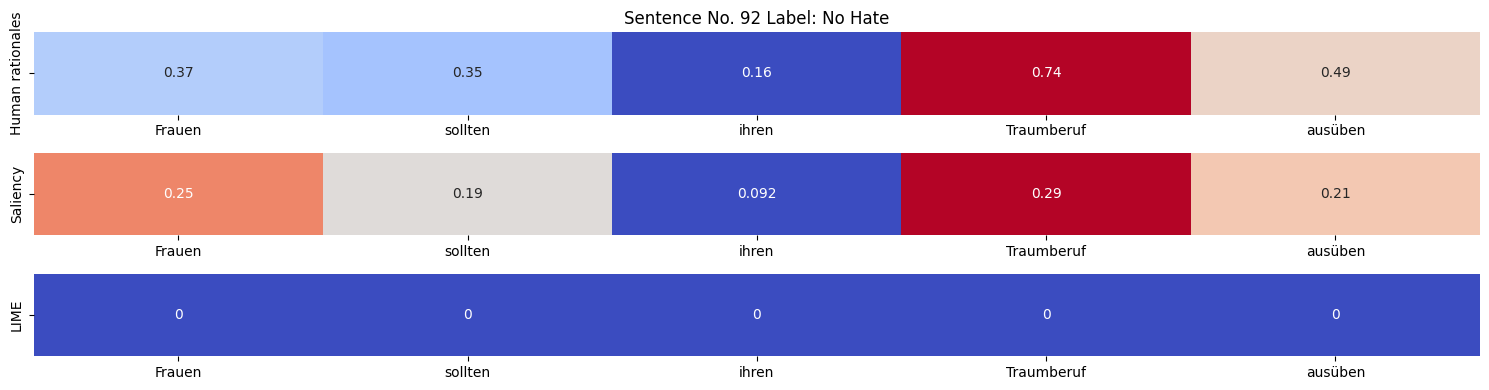

Plotting heatmap for rationales, saliency, and LIME for given sno: 93


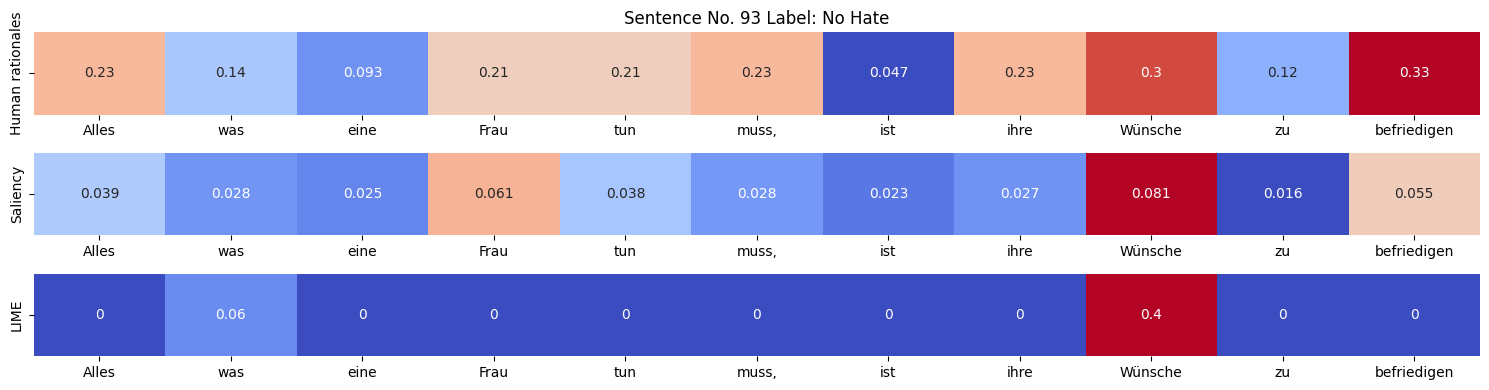

In [40]:
process_and_plot_heatmaps(human_rationales, correct_prediction_labels, BERT_rationales_SALIENCY, BERT_rationales_LIME, experiment_sents, dir_path_visual)

## References

Özge Alacam, Sanne Hoeken, and Sina Zarrieß. 2024. Eyes don‘t lie: Subjective hate annotation and detection with gaze. In *Proceedings of the 2024 Conference on Empirical Methods in Natural Language Processing*, pages 187–205, Miami, Florida, USA. Association for Computational Linguistics.

Pepa Atanasova, Jakob Grue Simonsen, Christina Lioma, and Isabelle Augenstein. 2020. A diagnostic
study of explainability techniques for text classification. In *Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP)*, pages 3256–3274, Online. Association for Computational Linguistics.

Sarthak Roy, Ashish Harshvardhan, Animesh Mukherjee, and Punyajoy Saha. 2023. Probing LLMs for hate speech detection: strengths and vulnerabilities. In *Findings of the Association for Computational Linguistics: EMNLP 2023*, pages 6116–6128, Singapore. Association for Computational Linguistics.